In [1]:
##################################
### Import the usual libraries ###
##################################

#numpy
import numpy as np

# scipy
from scipy.stats import binned_statistic

#astropy
import astropy
from astropy.io import fits, ascii
from astropy.table import Table, Column, QTable

#matplotlib
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.patches as mpatches
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, AutoMinorLocator
from matplotlib.offsetbox import AnchoredText

# Yumi's Code to convert (RA,DEC) to MS coordinates
import MagellanicStream as ms

# .py files for grad calc
import astrofunctions as astro
import lmcgeometry as lgeo
import mlefitting as mle
import utilities as util

# Ignore warnings unless crashes
import warnings
warnings.filterwarnings('ignore')

#progress bars
from tqdm import tqdm_notebook

In [2]:
# PARSEC Isochrones
parsecall = ascii.read('/Users/joshpovick/Desktop/Research/LMC_Ages/parsec3_3.dat', \
                    format='basic', delimiter='\s')

rgb = np.where(parsecall['label']==3)
parsec = parsecall[rgb]

# LMC r13 data
lmcr13 = fits.getdata('/Users/joshpovick/Desktop/Research/LMC_Ages/lmc_rgbmembers.r13-l33-58672.fits.gz',1)
clnr = np.where((lmcr13['FE_H']>-9999.0)&(lmcr13['AK_TARG']>-9999.0)&(lmcr13['LOGG']>0.0)&
                (lmcr13['M_H_ERR']>-90.0)&(lmcr13['C_FE']>-9999.0)&(lmcr13['N_FE']>-9999.0))

r13 = lmcr13[clnr]

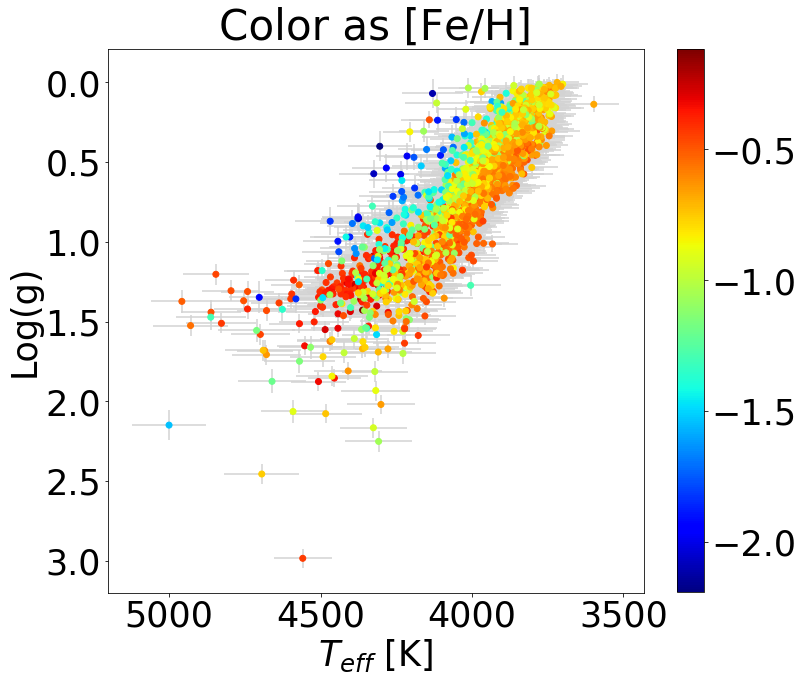

In [138]:
plt.figure(figsize=[12,10])
plt.errorbar(r13['TEFF'],r13['LOGG'],xerr=r13['TEFF_ERR'],yerr=r13['LOGG_ERR'],c='lightgrey',zorder=1,ls='none')
plt.scatter(r13['TEFF'],r13['LOGG'],c=r13['FE_H'],cmap='jet',zorder=2)
plt.colorbar()

plt.gca().invert_yaxis()
plt.gca().invert_xaxis()

plt.title(r'Color as [Fe/H]')
plt.xlabel(r'$T_{eff}$ [K]')
plt.ylabel(r'Log(g)')

plt.savefig('DR16CMD.pdf',bbox_inches='tight')
plt.show()

In [59]:
### Radii LMC
x,y,dist = lgeo.LMCdisk_cart(r13['RA'],r13['DEC'])
radius = lgeo.elliptical_radius(x,y)
     
### All elements APOGEE measures abundances for
elems = ['M_H','C_FE','N_FE','O_FE','NA_FE','MG_FE','AL_FE','SI_FE','P_FE','S_FE','K_FE','CA_FE','TI_FE',
         'TIII_FE','V_FE','CR_FE','MN_FE','FE_H','CO_FE','NI_FE','CU_FE','GE_FE','RB_FE','CE_FE','ND_FE','YB_FE']
elems_err = ['M_H_ERR','C_FE_ERR','N_FE_ERR','O_FE_ERR','NA_FE_ERR','MG_FE_ERR','AL_FE_ERR','SI_FE_ERR',
             'P_FE_ERR','S_FE_ERR','K_FE_ERR','CA_FE_ERR','TI_FE_ERR','TIII_FE_ERR','V_FE_ERR','CR_FE_ERR',
             'MN_FE_ERR','FE_H_ERR','CO_FE_ERR','NI_FE_ERR','CU_FE_ERR','GE_FE_ERR','RB_FE_ERR','CE_FE_ERR',
             'ND_FE_ERR','YB_FE_ERR']

labs = ['[M/H]','[C/Fe]','[N/Fe]','[O/Fe]','[Na/Fe]','[Mg/Fe]','[Al/Fe]','[Si/Fe]','[P/Fe]','[S/Fe]','[K/Fe]',
        '[Ca/Fe]','[Ti/FE]','[Ti II/Fe]','[V/Fe]','[Cr/Fe]','[Mn/Fe]','[Fe/H]','[Co/Fe]','[Ni/Fe]','[Cu/Fe]',
        '[Ge/Fe]','[Rb/Fe]','[Ce/Fe]','[Nd/Fe]','[Yb/FE]']

In [170]:
xx,yy = np.meshgrid(np.linspace(-8,8,100),np.linspace(-8,8,100))

In [198]:
psi = np.radians(227.24+90.0)
b_a = 0.839

clabx = (np.arange(7)+1)*np.sqrt(1/(np.cos(psi)**2+np.sin(psi)**2/b_a))

locations = []
for i in range(len(clabx)):
    locations.append([0.0,clabx[i]])

[[0.0, 0.9585067203419629],
 [0.0, 1.9170134406839259],
 [0.0, 2.875520161025889],
 [0.0, 3.8340268813678517],
 [0.0, 4.792533601709815],
 [0.0, 5.751040322051778],
 [0.0, 6.709547042393741]]

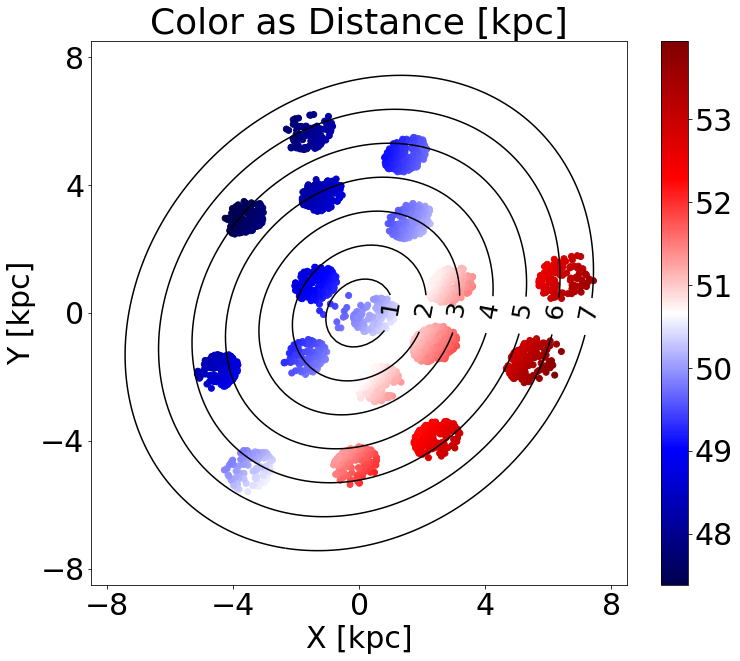

In [229]:
psi = np.radians(227.24+90.0)
b_a = 0.839

clabx = (np.arange(7)+1)*np.sqrt(1/(np.cos(psi)**2+np.sin(psi)**2/b_a))

locations = []
for i in range(len(clabx)):
    locations.append([clabx[i],0.0])

matplotlib.rcParams.update({'font.size': 30})
plt.figure(figsize=[12,10])

plt.scatter(x,y,c=dist,cmap='seismic')
plt.colorbar()

xx,yy = np.meshgrid(np.linspace(-8,8,100),np.linspace(-8,8,100))
CS = plt.contour(xx,yy,lgeo.elliptical_radius(xx,yy),levels=[1,2,3,4,5,6,7],colors='k')
plt.clabel(CS,fmt='%2.1d',colors='k',fontsize=25,manual=locations)

plt.xticks([-8,-4.0,0,4.0,8])
plt.yticks([-8,-4.0,0,4.0,8])

plt.xlim(-8.5,8.5)
plt.ylim(-8.5,8.5)

plt.title(r'Color as Distance [kpc]')
plt.xlabel(r'X [kpc]')
plt.ylabel(r'Y [kpc]')

plt.savefig('lmcGeometry.pdf',bbox_inches='tight')
plt.show()

In [248]:
initialfit = fits.getdata('initialfit.fits')
initialfit[17]

('Fe_H', -0.03743413201474323, -0.5943873092902547)

0.3750535210998492


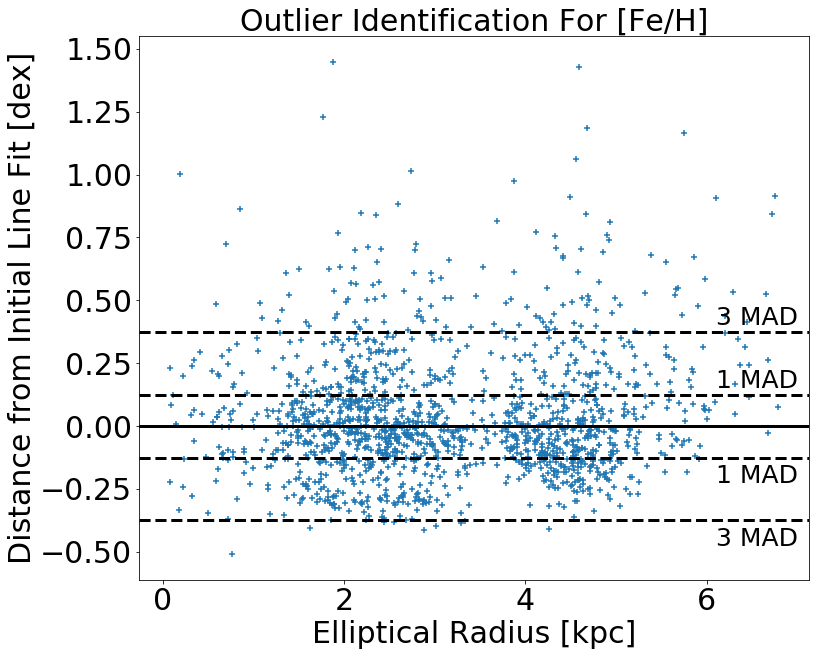

In [324]:
### Distance from initial fit

initialfit = fits.getdata('initialfit.fits')

# fe_idx = np.where(initialfit['X_FE']=='Fe_H')

# # matplotlib.rcParams.update({'font.size': 18})
# med_elems_dist = []
# for i in tqdm_notebook(range(len(elems)-5),desc='Done?'):
    
#     def trendline(x):
#         return med_ms[i]*x+med_bs[i]
    
#     cln = np.where((r13[elems[i]]>-100)&(r13['SNR']>=100))
#     plug = trendline(radius[cln])
#     dist = plug-r13[elems[i]][cln]
    
#     med_elems_dist.append(dist)    
    
#     bins = np.append(np.arange(np.floor(np.min(radius[cln])),np.ceil(np.max(radius[cln])),1.0),
#                      np.ceil(np.max(radius[cln]))+1) 
#     bin_dist, _, _ = binned_statistic(radius[cln],dist,statistic='median',bins=bins)
#     bin_spr, _, _ = binned_statistic(radius[cln],dist,statistic=lambda y: np.median(np.absolute(y-np.median(y))),
#                                      bins=bins)
    
#     plt.figure(figsize=[12,10])
#     plt.scatter(radius[cln],dist,marker='+')
#     plt.errorbar(bins[:-1]+0.5,bin_dist,yerr=3*bin_spr,c='r',ls='none',lw=3)
#     plt.errorbar(bins[:-1]+0.5,bin_dist,yerr=bin_spr,c='k',capsize=5,lw=3)
#     plt.axhline(0.0,c='g',lw=3.0)
#     plt.title(r'{}'.format(labs[i]),fontsize=30,x=0.85,y=0.90)#,len(np.squeeze(cln))))
#     plt.xlabel(r'Elliptical Radius (kpc)')
#     plt.ylabel(r'Distance from Initial Line Fit (kpc)')
# #     plt.savefig('outliers{}'.format(elems[i]),bbox_inches='tight')
#     plt.show()
    
def initialiron(x):
    return initialfit['GRAD'][17]*x + initialfit['INTER'][17]

cln = np.where((r13['FE_H']>-100)&(r13['SNR']>=100))
plug = initialiron(radius[cln])
dist = plug-r13['FE_H'][cln]

print(3*util.mad(dist))

# med_elems_dist.append(dist)

bins = np.append(np.arange(np.floor(np.min(radius[cln])),np.ceil(np.max(radius[cln])),1.0),
                     np.ceil(np.max(radius[cln]))+1) 
bin_dist, _, _ = binned_statistic(radius[cln],dist,statistic='median',bins=bins)
bin_spr, _, _ = binned_statistic(radius[cln],dist,statistic=lambda y: np.median(np.absolute(y-np.median(y))),
                                     bins=bins)

plt.figure(figsize=[12,10])
plt.scatter(radius[cln],dist,marker='+')
plt.axhline(util.mad(dist),c='k',lw=3.0,ls='--',label='1 MAD')
plt.axhline(-util.mad(dist),c='k',lw=3.0,ls='--')
plt.axhline(3*util.mad(dist),c='k',lw=3.0,ls='--',label='3 MAD')
plt.axhline(-3.0*util.mad(dist),c='k',lw=3.0,ls='--')
# plt.errorbar(bins[:-1]+0.5,bin_dist,yerr=3*bin_spr,c='r',ls='none',lw=3)
# plt.errorbar(bins[:-1]+0.5,bin_dist,yerr=bin_spr,c='k',capsize=5,lw=3)
plt.axhline(0.0,c='k',lw=3.0)

# plt.legend(loc='upper left')

plt.text(6.1,util.mad(dist)*(1.0+0.1)+0.015,'1 MAD',fontsize=25)
plt.text(6.1,-util.mad(dist)*(1.0+0.1)-0.09,'1 MAD',fontsize=25)

plt.text(6.1,3.0*util.mad(dist)*(1.0+0.1)-0.01,'3 MAD',fontsize=25)
plt.text(6.1,-3.0*util.mad(dist)*(1.0+0.1)-0.065,'3 MAD',fontsize=25)

plt.title(r'Outlier Identification For [Fe/H]',fontsize=30)#,len(np.squeeze(cln))))
plt.xlabel(r'Elliptical Radius [kpc]')
plt.ylabel(r'Distance from Initial Line Fit [dex]')
plt.savefig('fehOutliers.pdf',bbox_inches='tight')
plt.show()

In [251]:
radius[cln]

array([1.09193042, 1.07993892, 1.0564974 , ..., 5.74713355, 5.80986768,
       5.98728527])

In [36]:
### Import Ages and Gradients

# ages
ages = fits.getdata('TEST_pca_ols_ages.fits')

young = np.where(ages['AGE']<=np.log10(0.5*10**9))
yless = np.where((ages['AGE']>np.log10(0.5*10**9))&(ages['AGE']<=np.log10(2.0*10**9)))
ymed = np.where((ages['AGE']>np.log10(2.0*10**9))&(ages['AGE']<=np.log10(7*10**9)))
omed = np.where((ages['AGE']>np.log10(7*10**9))&(ages['AGE']<=np.log10(10.5*10**9)))
old = np.where(ages['AGE']>np.log10(10.5*10**9))

r13young = r13[young]
r13yless = r13[yless]
r13ymed = r13[ymed]
r13omed = r13[omed]
r13old = r13[old]

### Gradients
overallgrads = fits.getdata('overallgrads.fits') 
younggrads = fits.getdata('younggrads.fits')
ylessgrads = fits.getdata('ylessgrads.fits')
ymedgrads = fits.getdata('ymedgrads.fits')
omedgrads = fits.getdata('omedgrads.fits')
oldgrads = fits.getdata('oldgrads.fits')

### Running Median Trends
youngtrends = fits.getdata('youngtrends.fits')
for i in range(len(youngtrends)):
    for j in range(6):
        if youngtrends['STATS'][i][j] == -9999.0:
            youngtrends['STATS'][i][j] = np.nan
            youngtrends['SPREAD'][i][j] = np.nan

ylesstrends = fits.getdata('ylesstrends.fits')
for i in range(len(ylesstrends)):
    for j in range(7):
        if ylesstrends['STATS'][i][j] == -9999.0:
            ylesstrends['STATS'][i][j] = np.nan
            ylesstrends['SPREAD'][i][j] = np.nan
                      
ymedtrends = fits.getdata('ymedtrends.fits')
for i in range(len(ymedtrends)):
    for j in range(6):
        if ymedtrends['STATS'][i][j] == -9999.0:
            ymedtrends['STATS'][i][j] = np.nan
            ymedtrends['SPREAD'][i][j] = np.nan
                       
omedtrends = fits.getdata('omedtrends.fits')
for i in range(len(omedtrends)):
    for j in range(6):
        if omedtrends['STATS'][i][j] == -9999.0:
            omedtrends['STATS'][i][j] = np.nan
            omedtrends['SPREAD'][i][j] = np.nan
            
oldtrends = fits.getdata('oldtrends.fits')
for i in range(len(oldtrends)):
    for j in range(6):
        if oldtrends['STATS'][i][j] == -9999.0:
            oldtrends['STATS'][i][j] = np.nan
            oldtrends['SPREAD'][i][j] = np.nan

In [34]:
print(younggrads.columns)
print(youngtrends.columns)

ColDefs(
    name = 'X_FE'; format = '7A'
    name = 'GRAD'; format = 'D'
    name = 'GRAD_ERR'; format = 'D'
    name = 'INTER'; format = 'D'
    name = 'INTER_ERR'; format = 'D'
)
ColDefs(
    name = 'X_FE'; format = '7A'
    name = 'STATS'; format = '6D'
    name = 'SPREAD'; format = '6D'
)


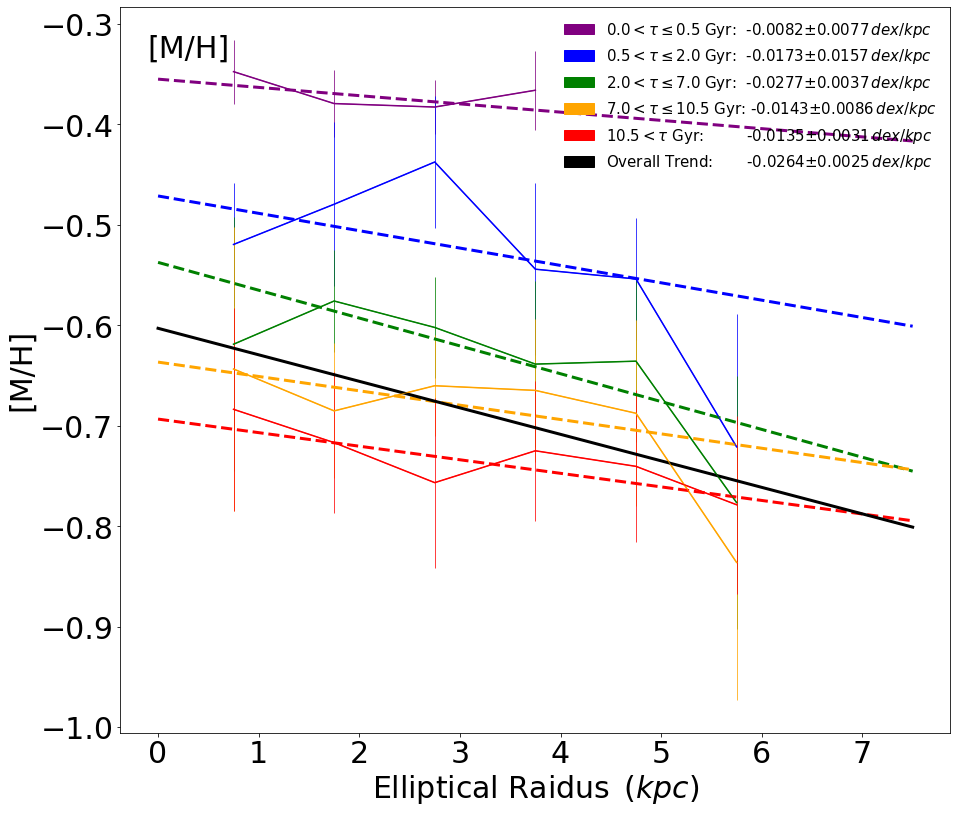

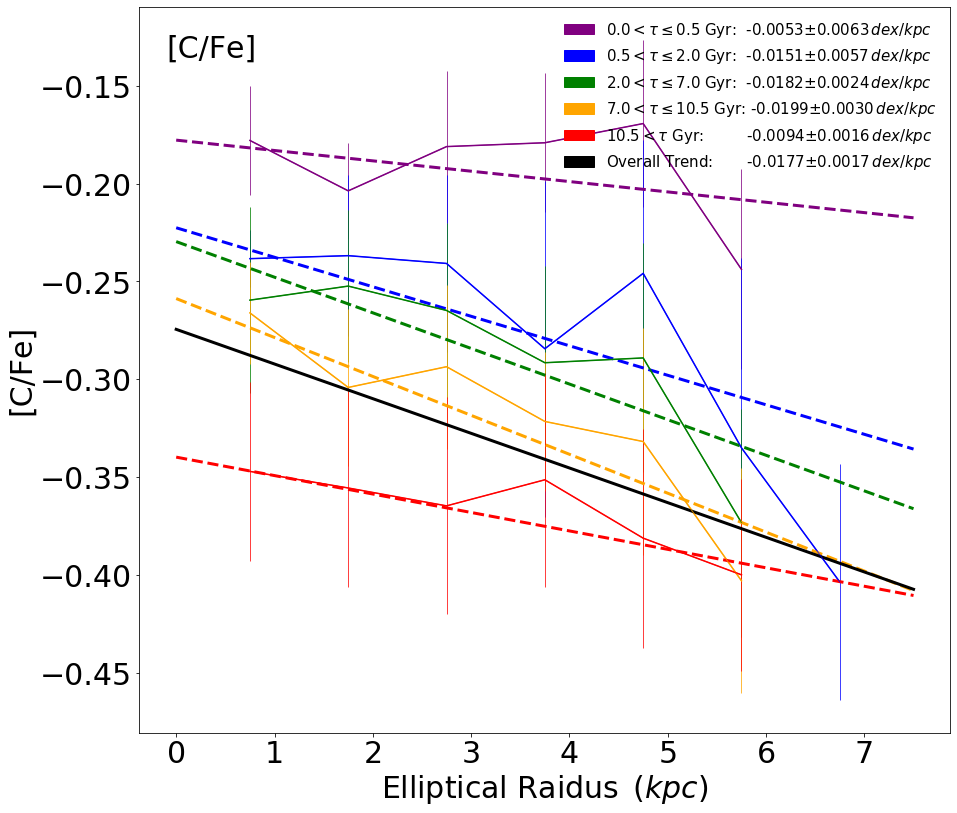

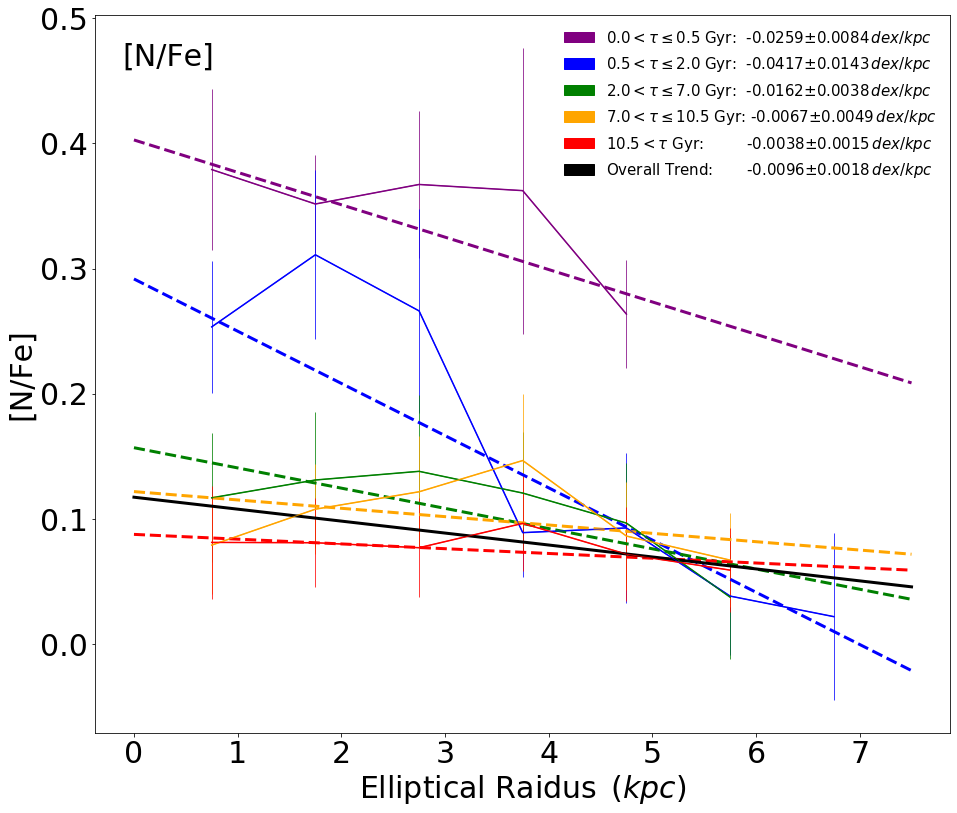

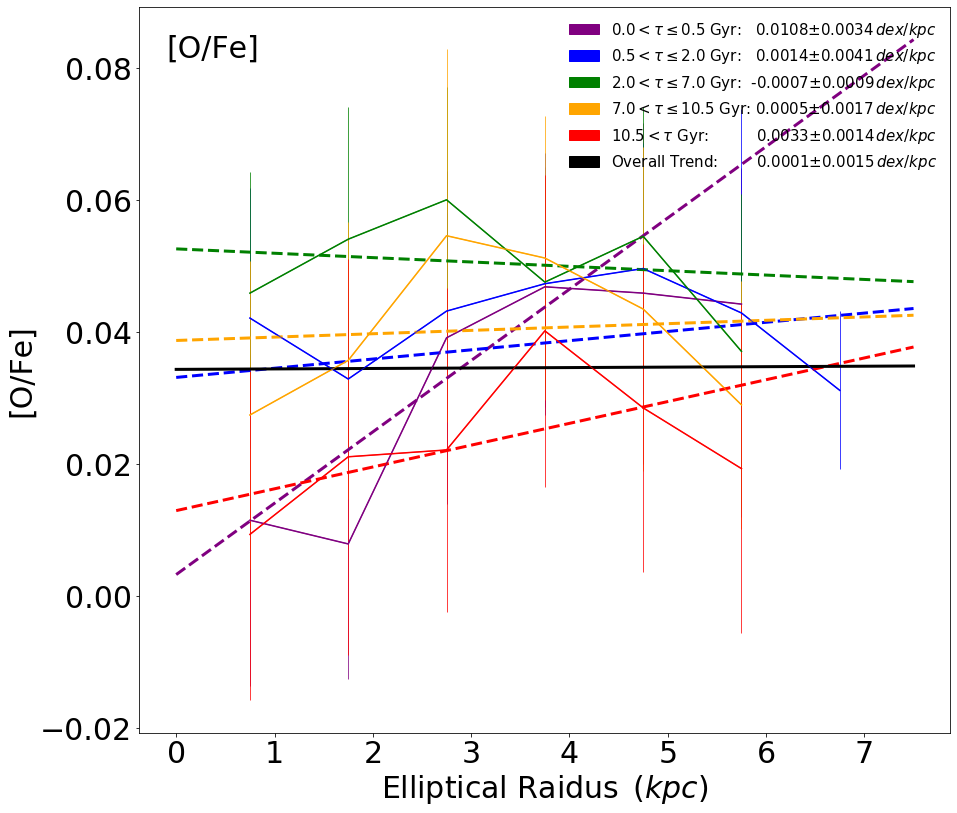

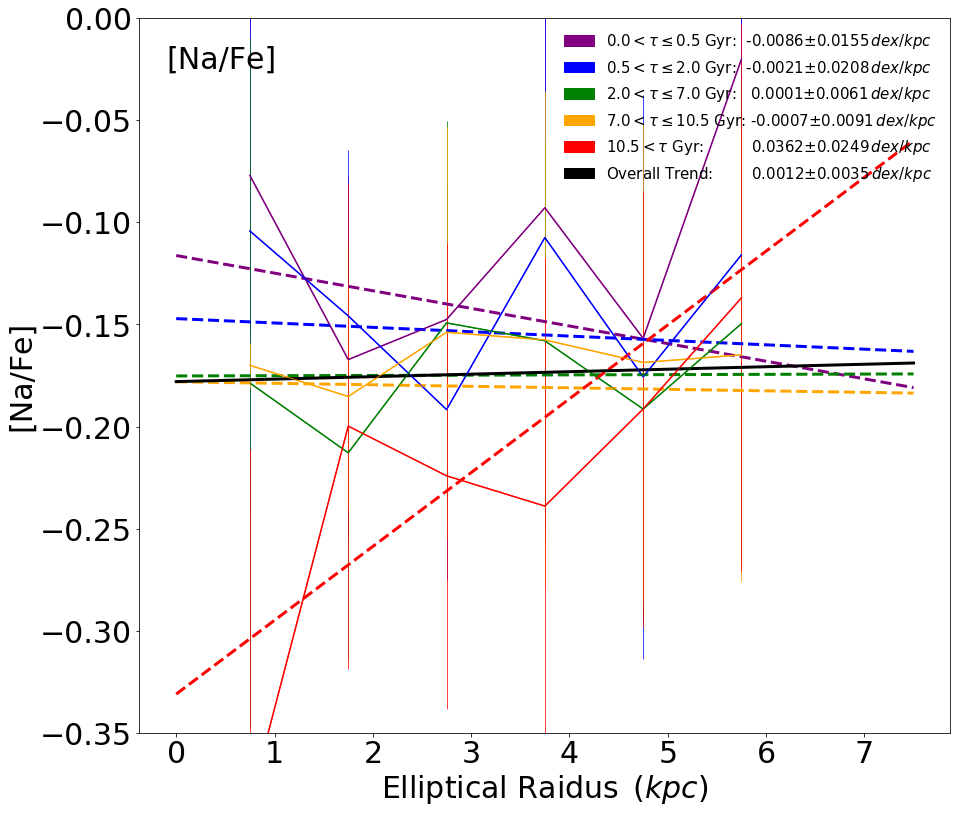

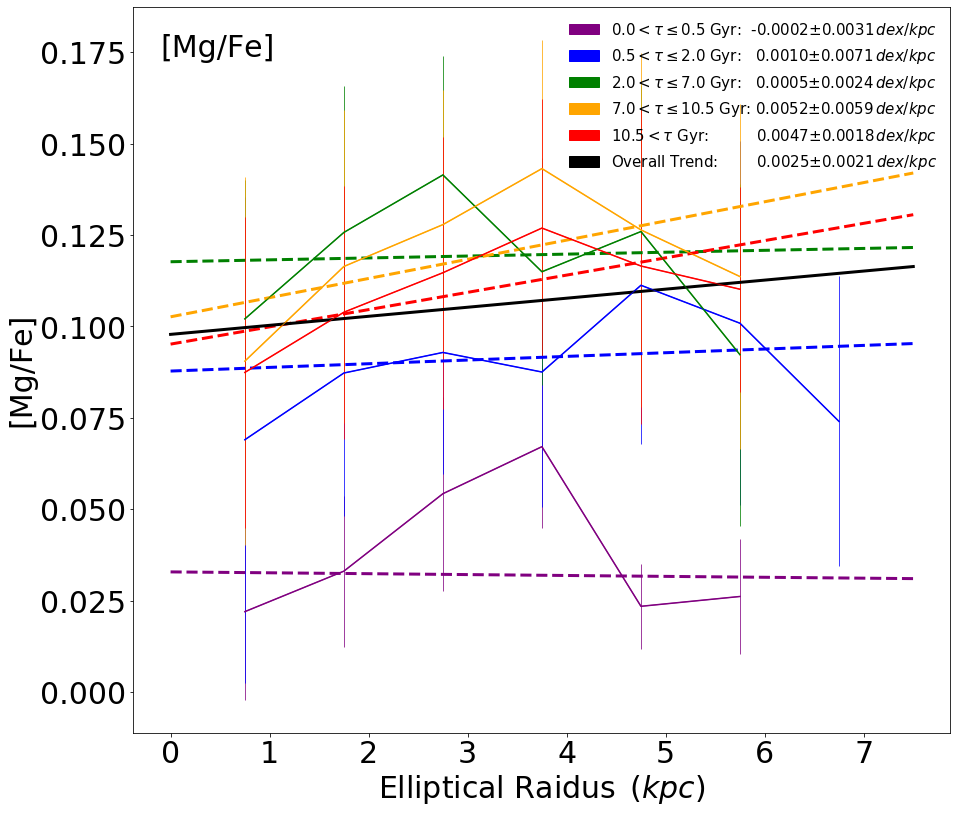

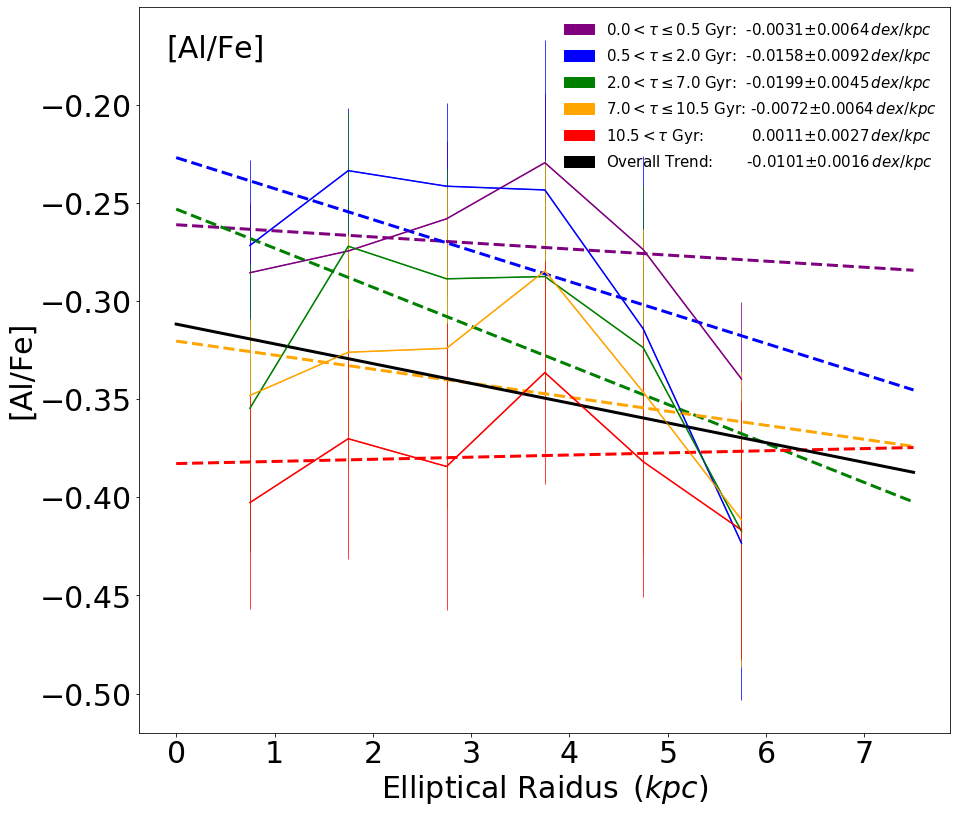

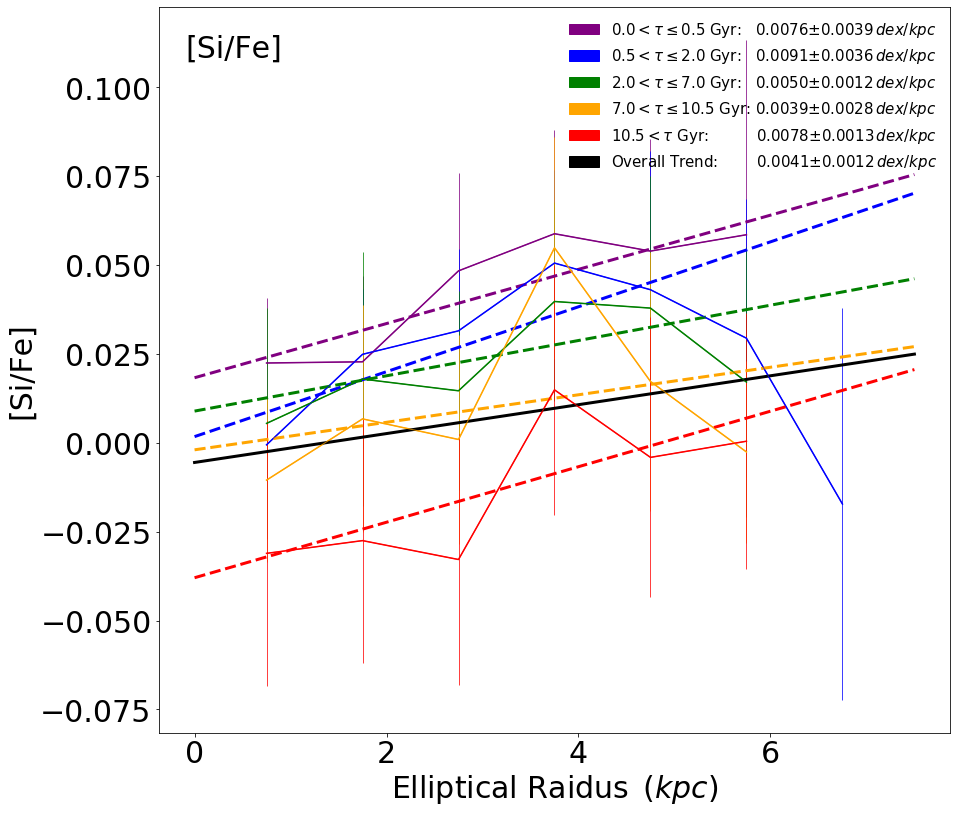

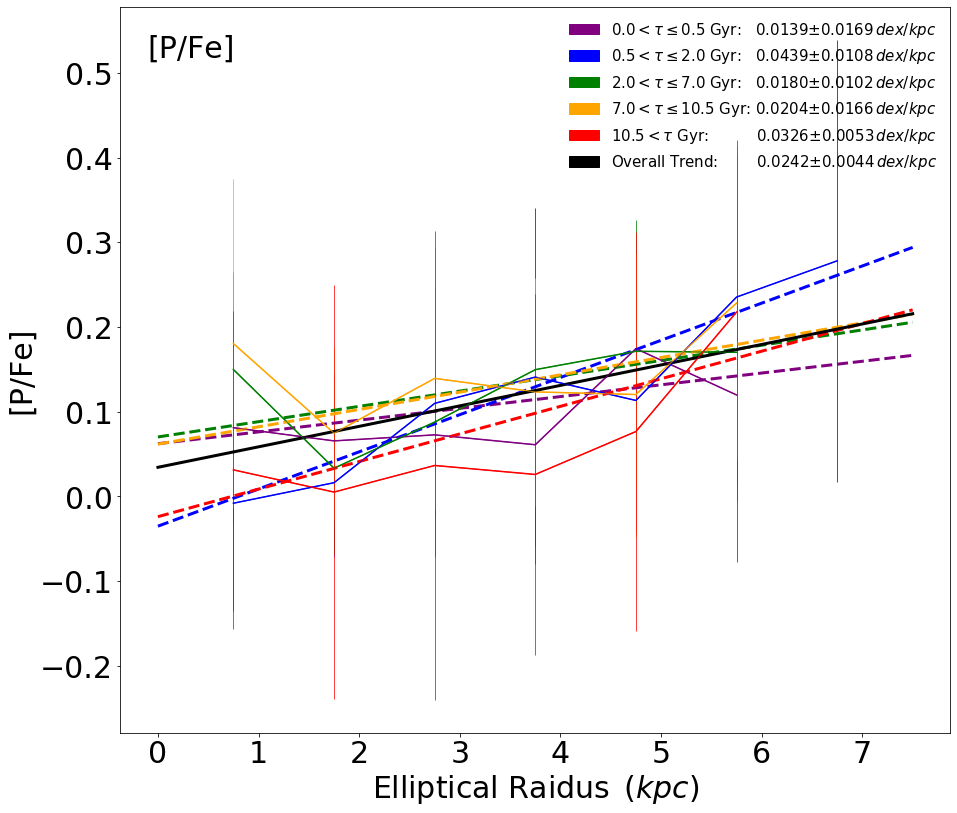

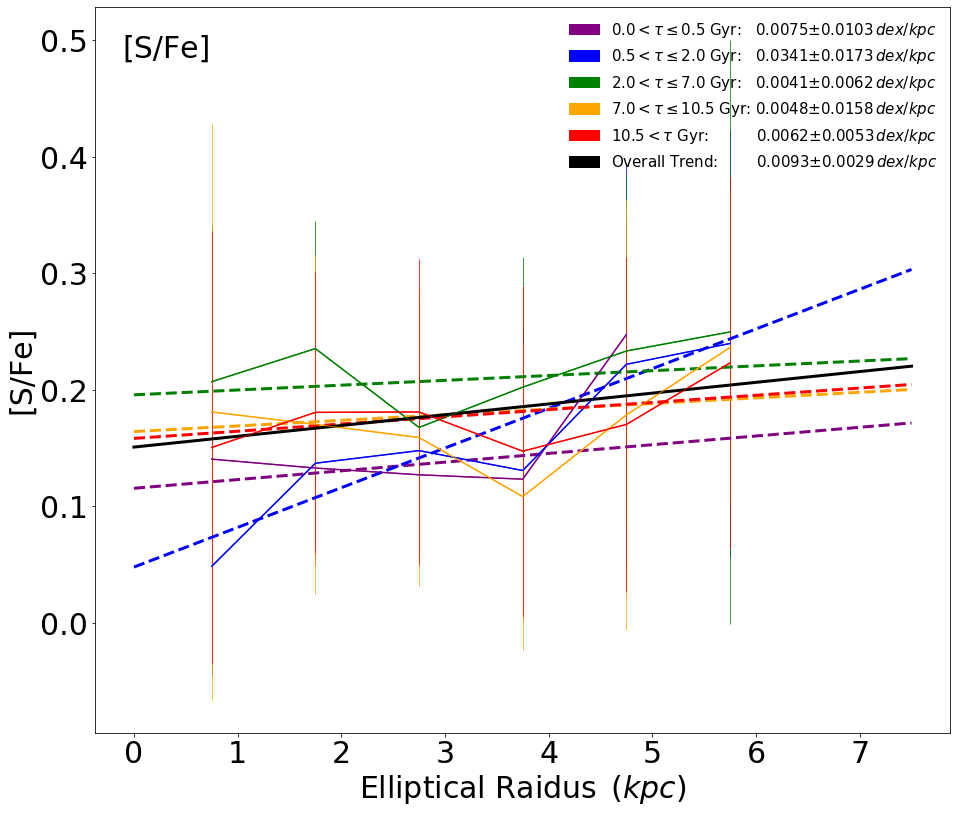

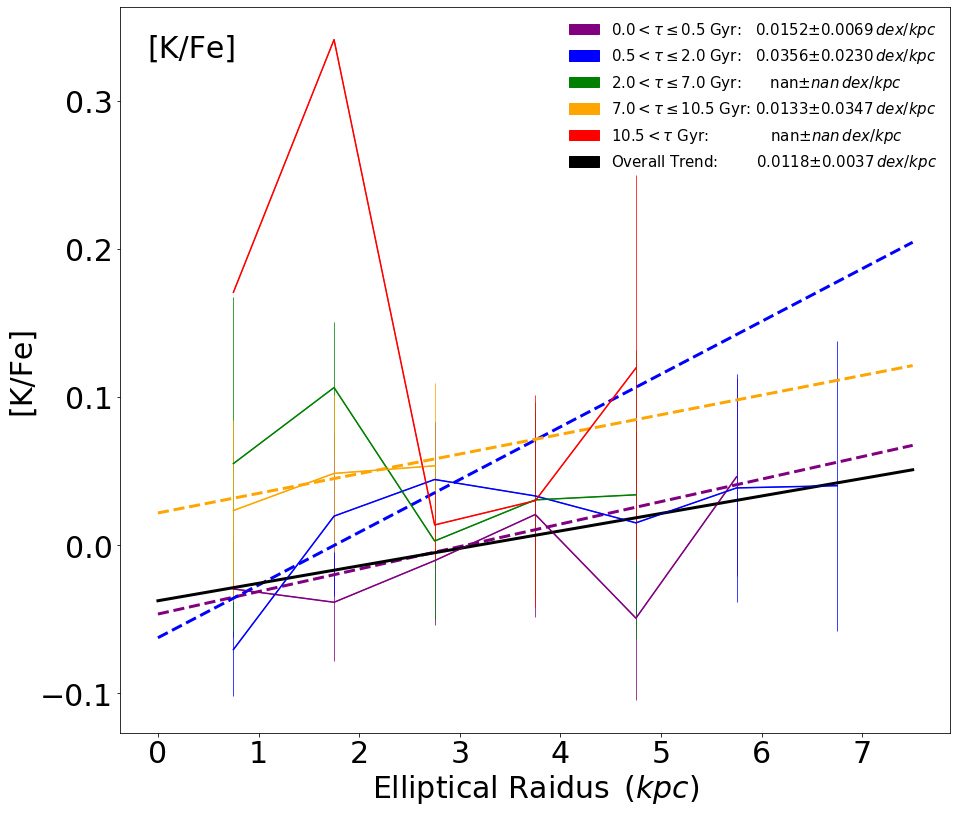

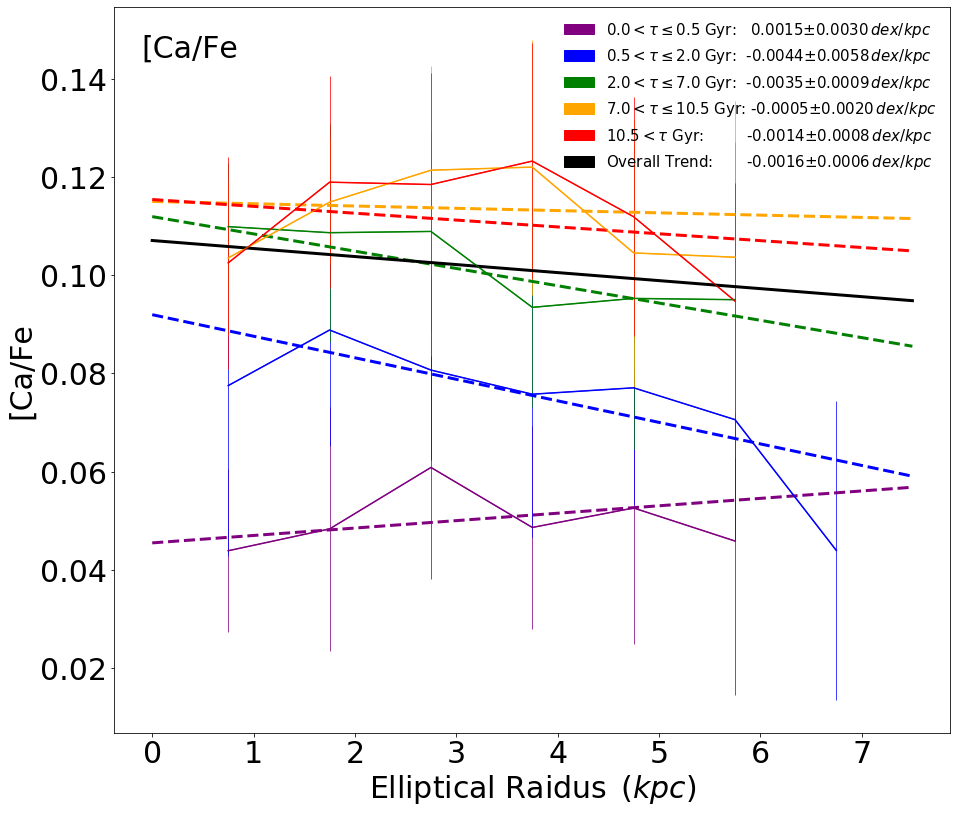

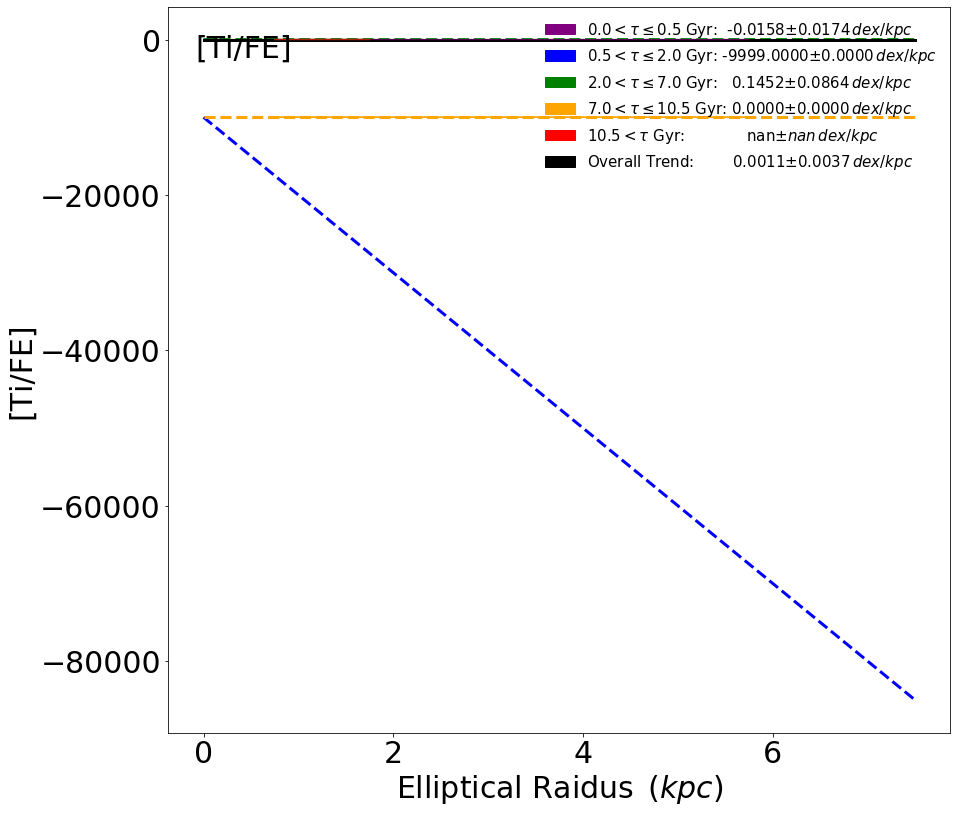

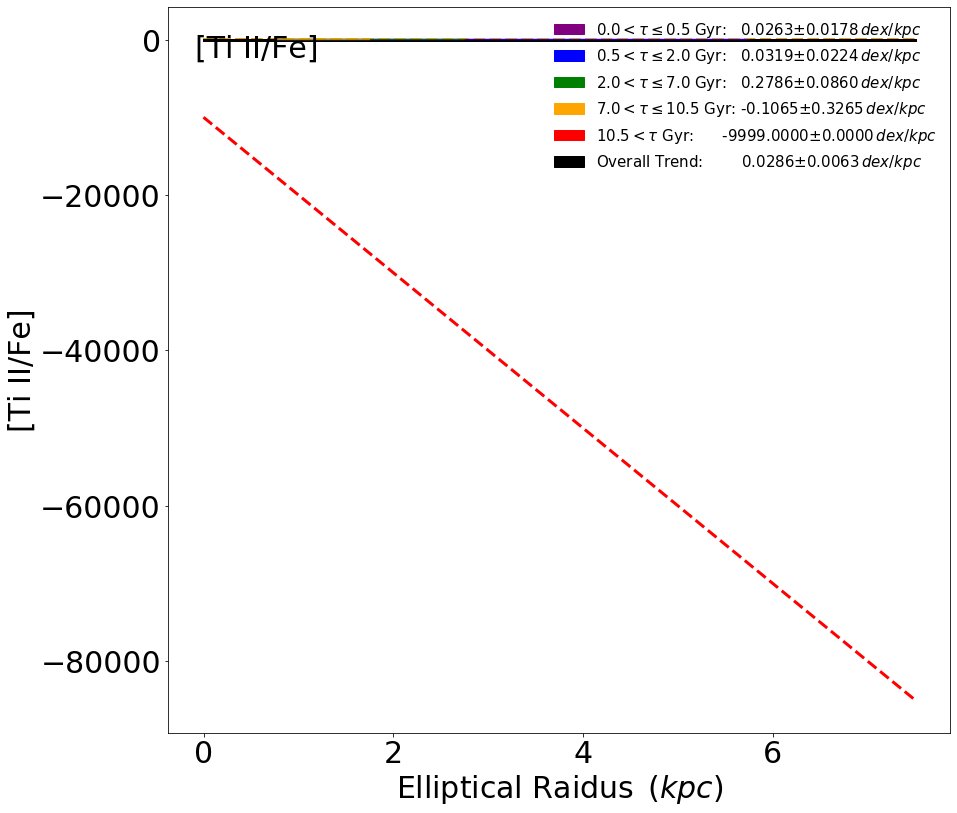

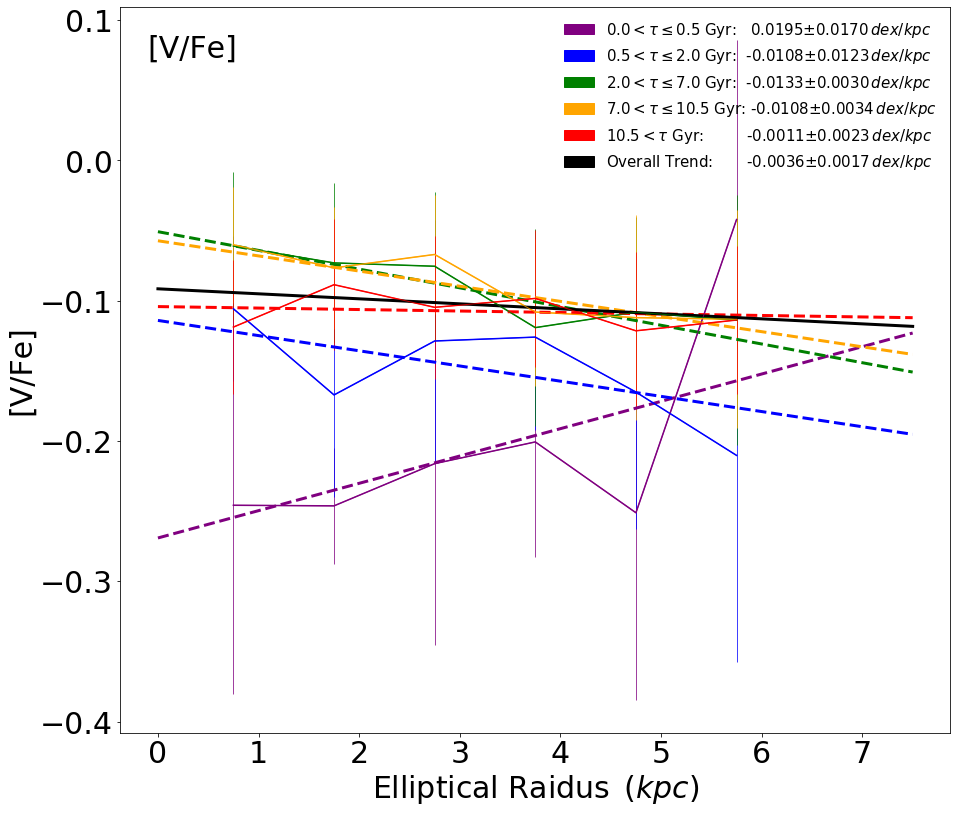

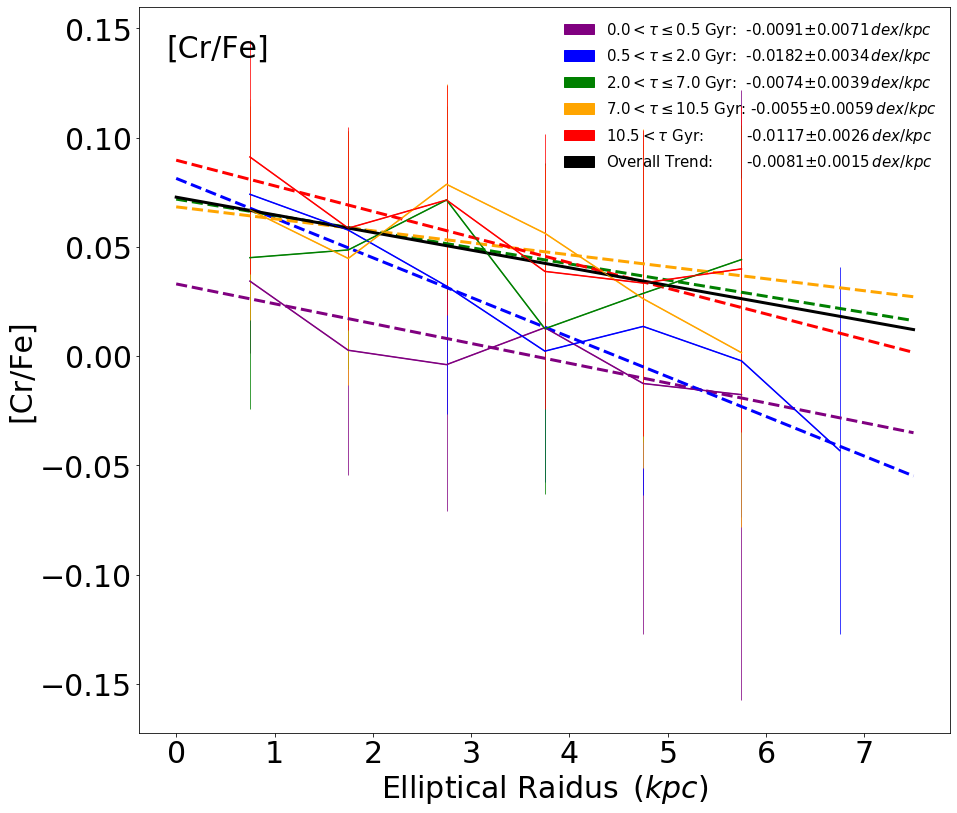

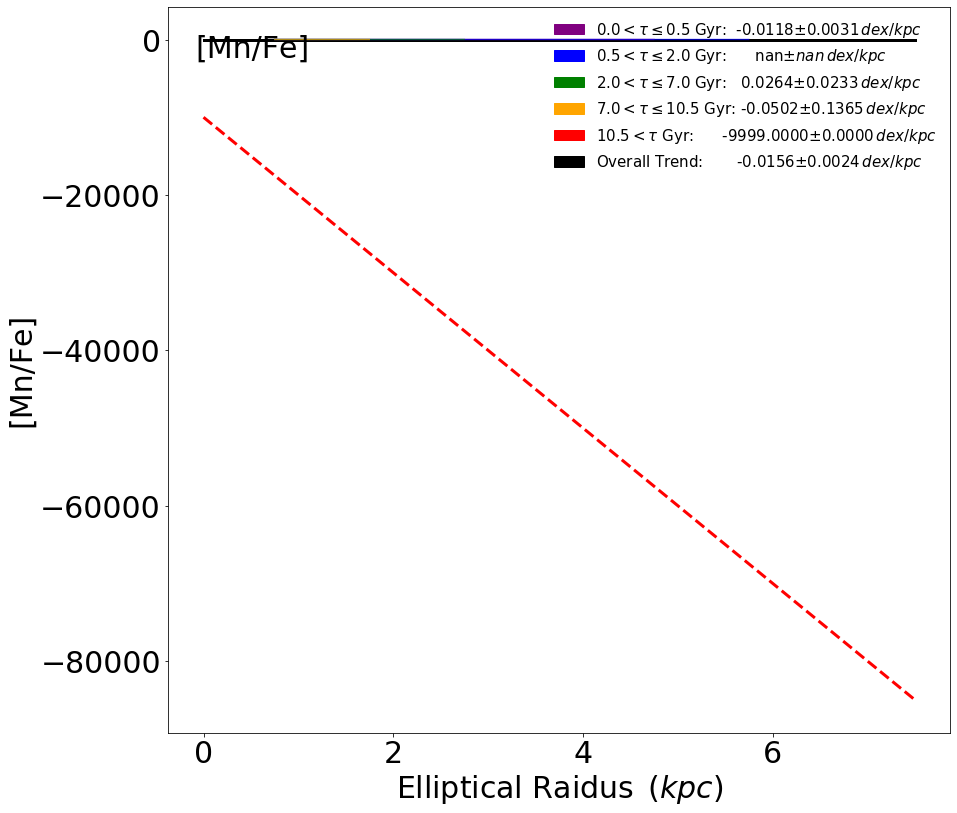

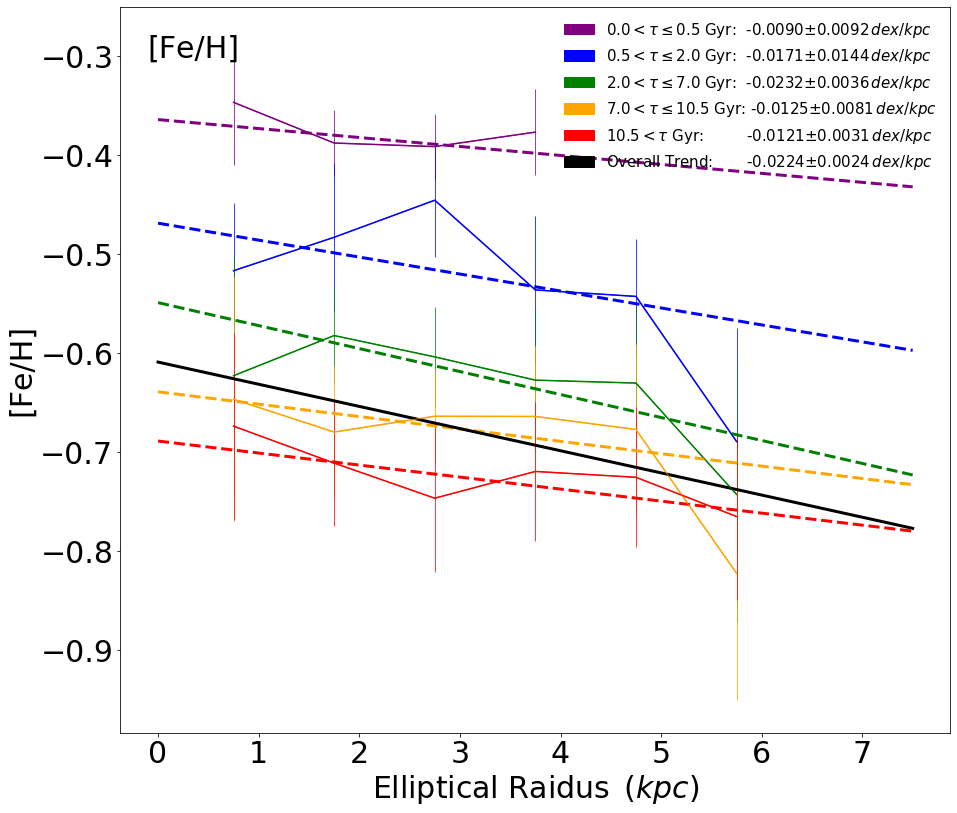

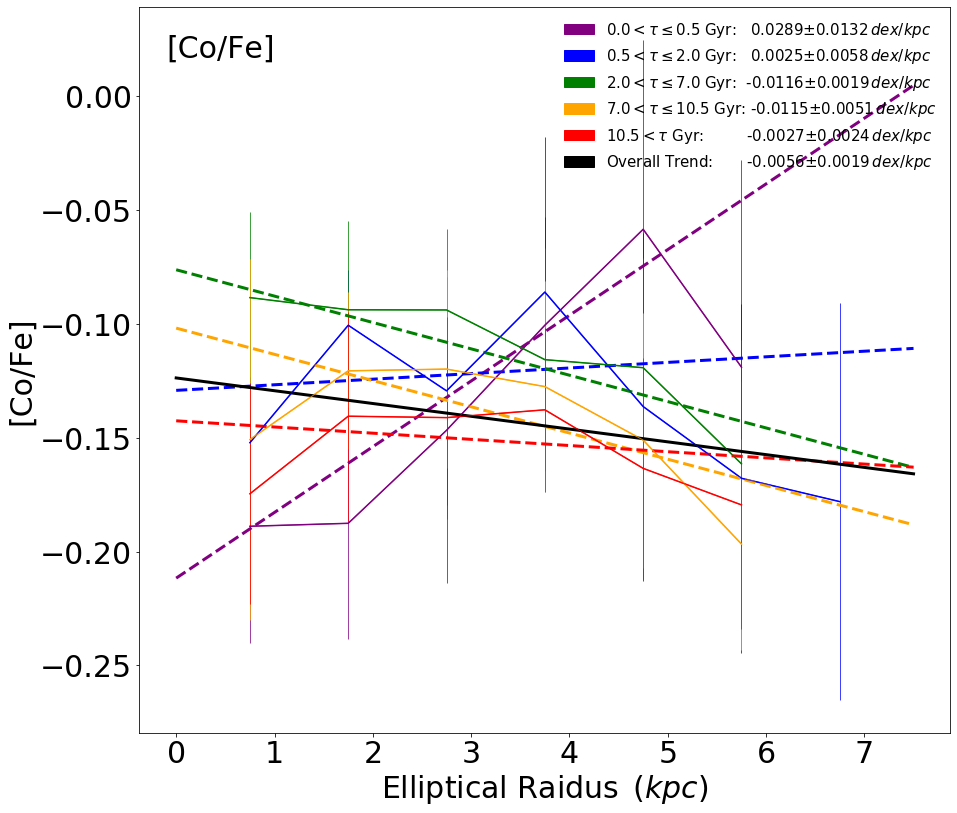

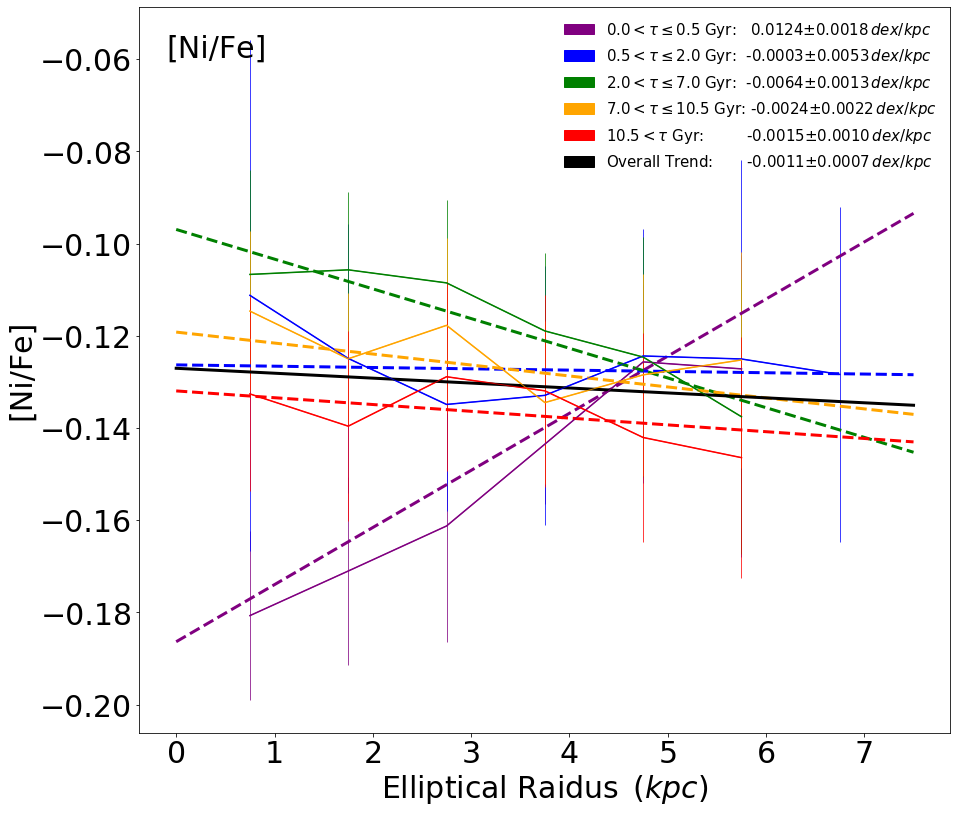

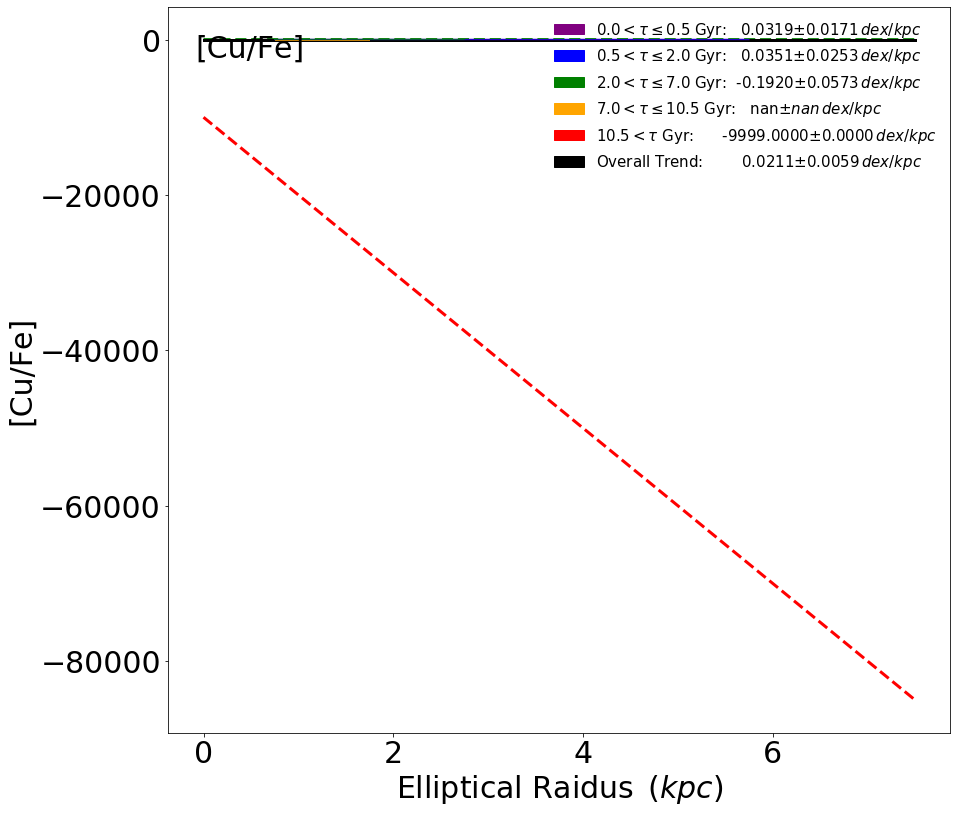

In [37]:
ytops = [0,0.1,0.7,0.2,1.0,0.4,0,0.325,2.0,0.8,0.8,0.3,0,0,0.75,0.4,0,0.0,0.5,0.0,0,0,0,0,0,0]

matplotlib.rcParams.update({'font.size': 30})
import matplotlib.patches as mpatches

young_parage = np.asarray(ages)[young]
yless_parage = np.asarray(ages)[yless]
ymed_parage = np.asarray(ages)[ymed]
omed_parage = np.asarray(ages)[omed]
old_parage = np.asarray(ages)[old]

for i in tqdm_notebook(range(len(elems)-5),desc='plots',leave=False):
    xval = np.linspace(0.0,7.5)
    
    def youngtrendline(x):
        return younggrads['GRAD'][i]*x+younggrads['INTER'][i]
    def ylesstrendline(x):
        return ylessgrads['GRAD'][i]*x+ylessgrads['INTER'][i]
    def ymedtrendline(x):
        return ymedgrads['GRAD'][i]*x+ymedgrads['INTER'][i]
    def omedtrendline(x):
        return omedgrads['GRAD'][i]*x+omedgrads['INTER'][i]
    def oldtrendline(x):
        return oldgrads['GRAD'][i]*x+oldgrads['INTER'][i]
    def trendline(x):
        return overallgrads['GRAD'][i]*x+overallgrads['INTER'][i]
        
    fig = plt.figure(figsize=[14,12])
    
    ### young
    plt.errorbar(np.arange(len(youngtrends['STATS'][i]))+0.5+0.25,youngtrends['STATS'][i],
                 yerr=youngtrends['SPREAD'][i],color='purple',ls='-',alpha=0.75,lw=1)
    plt.plot(np.arange(len(youngtrends['STATS'][i]))+0.5+0.25,youngtrends['STATS'][i],color='purple')
    plt.plot(xval,youngtrendline(xval),c='purple',lw=3.0,ls='--') #young
    
    ### yless
    plt.errorbar(np.arange(len(ylesstrends['STATS'][i]))+0.5+0.25,ylesstrends['STATS'][i],
                 yerr=ylesstrends['SPREAD'][i],color='blue',ls='-',alpha=0.75,lw=1)
    plt.plot(np.arange(len(ylesstrends['STATS'][i]))+0.5+0.25,ylesstrends['STATS'][i],color='blue')
    plt.plot(xval,ylesstrendline(xval),c='blue',lw=3.0,ls='--') #yless
    
    ### ymed
    plt.errorbar(np.arange(len(ymedtrends['STATS'][i]))+0.5+0.25,ymedtrends['STATS'][i],
                 yerr=ymedtrends['SPREAD'][i],color='green',ls='-',alpha=0.75,lw=1)
    plt.plot(np.arange(len(ymedtrends['STATS'][i]))+0.5+0.25,ymedtrends['STATS'][i],color='green')
    plt.plot(xval,ymedtrendline(xval),c='green',lw=3.0,ls='--') #ymed

    ### omed
    plt.errorbar(np.arange(len(omedtrends['STATS'][i]))+0.5+0.25,omedtrends['STATS'][i],
                 yerr=omedtrends['SPREAD'][i],color='orange',ls='-',alpha=0.75,lw=1)
    plt.plot(np.arange(len(omedtrends['STATS'][i]))+0.5+0.25,omedtrends['STATS'][i],color='orange')
    plt.plot(xval,omedtrendline(xval),c='orange',lw=3.0,ls='--') #omed
    

    ### old
    plt.errorbar(np.arange(len(oldtrends['STATS'][i]))+0.5+0.25,oldtrends['STATS'][i],
                 yerr=oldtrends['SPREAD'][i],color='red',ls='-',alpha=0.75,lw=1)
    plt.plot(np.arange(len(oldtrends['STATS'][i]))+0.5+0.25,oldtrends['STATS'][i],color='red')
    plt.plot(xval,oldtrendline(xval),c='red',lw=3.0,ls='--') #old
    
    ### overall
    plt.plot(xval,trendline(xval),c='k',lw=3.0)
    
    handles,labels = plt.gca().get_legend_handles_labels()
    empty_young = mpatches.Patch(color='purple',label='$0.0 < \\tau \leq 0.5$ Gyr')
    empty_yless = mpatches.Patch(color='blue',label='$0.5 < \\tau \leq 2.0$ Gyr')
    empty_ymed = mpatches.Patch(color='green',label='$2.0 < \\tau \leq 7.0$ Gyr')
    empty_omed = mpatches.Patch(color='orange',label='$7.0 < \\tau \leq 10.5$ Gyr')
    empty_old = mpatches.Patch(color='red',label='$10.5 < \\tau$ Gyr')
    empty_over = mpatches.Patch(color='black',label='Overall Trend')
    
    handles.append(empty_young)
    handles.append(empty_yless)
    handles.append(empty_ymed)
    handles.append(empty_omed)
    handles.append(empty_old)
    handles.append(empty_over)
    
    labels.append('$0.0 < \\tau \leq 0.5$ Gyr: {:>8.4f}$\pm {:.4f} \,dex/kpc$'.format(younggrads['GRAD'][i],
                                                                                      younggrads['GRAD_ERR'][i]))
    labels.append('$0.5 < \\tau \leq 2.0$ Gyr: {:>8.4f}$\pm {:.4f} \,dex/kpc$'.format(ylessgrads['GRAD'][i],
                                                                                      ylessgrads['GRAD_ERR'][i]))
    labels.append('$2.0 < \\tau \leq 7.0$ Gyr: {:>8.4f}$\pm {:.4f} \,dex/kpc$'.format(ymedgrads['GRAD'][i],
                                                                                      ymedgrads['GRAD_ERR'][i]))
    labels.append('$7.0 < \\tau \leq 10.5$ Gyr: {:>5.4f}$\pm {:.4f} \,dex/kpc$'.format(omedgrads['GRAD'][i],
                                                                                       omedgrads['GRAD_ERR'][i]))
    labels.append('$10.5 < \\tau$ Gyr: {:>15.4f}$\pm {:.4f} \,dex/kpc$'.format(oldgrads['GRAD'][i],
                                                                               oldgrads['GRAD_ERR'][i]))
    labels.append('Overall Trend: {:>13.4f}$\pm {:.4f} \,dex/kpc$'.format(overallgrads['GRAD'][i],
                                                                          overallgrads['GRAD_ERR'][i]))
    
    plt.legend(handles,labels,loc='upper right',fontsize=15,frameon=False)

    plt.ylabel(r'{}'.format(labs[i]),fontsize=30)
    plt.xlabel(r'Elliptical Raidus $\,(kpc$)')
#     plt.ylim(top = ytops[i])
        
    if elems[i] == 'NA_FE':
        plt.ylim(-0.35,0.)
    
    ax0 = fig.add_subplot(111)
    at0 = AnchoredText('{}'.format(labs[i]),prop=dict(size=30),frameon=False,loc='upper left')
    at0.patch.set_boxstyle("square")
    ax0.add_artist(at0)
    
#     plt.savefig('medians_age_bins_{}2.png'.format(els[i]),bbox_inches='tight')
    plt.tight_layout()
#     plt.savefig('test_thisone_medians_age_bins_{}2.pdf'.format(els[i]),bbox_inches='tight')
    plt.show()

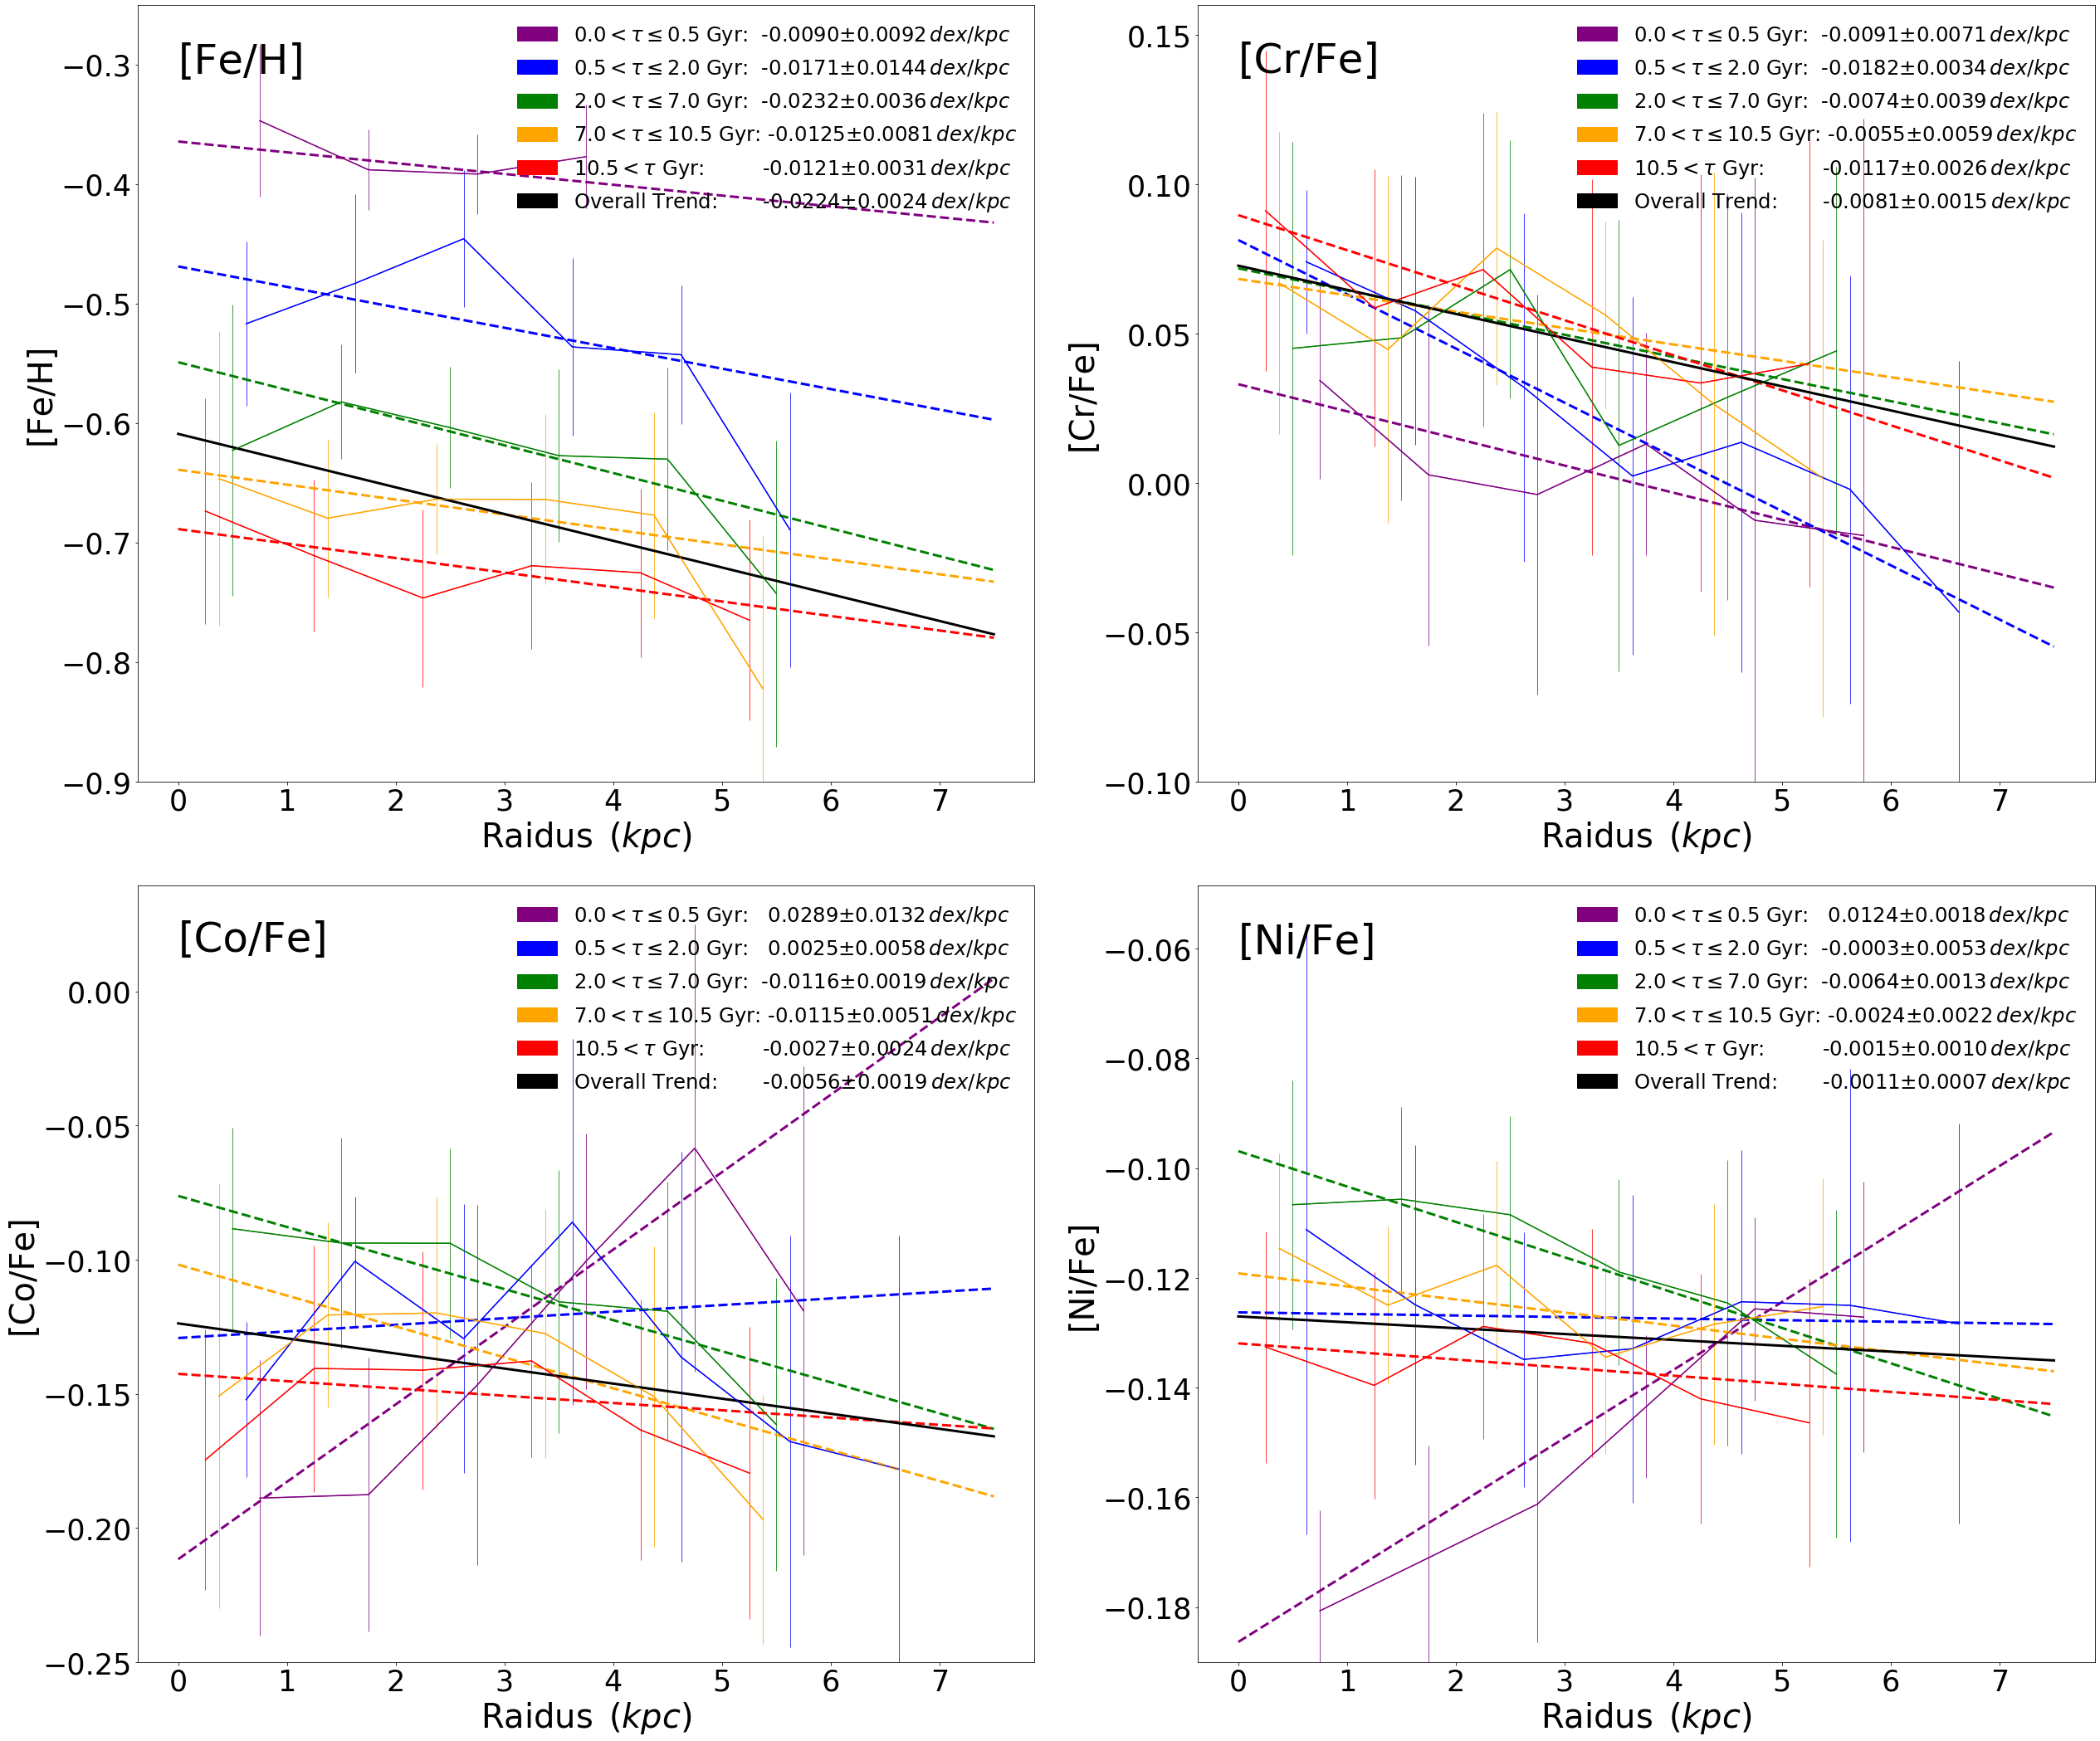

In [111]:
iron = [int(np.squeeze(np.where(np.asarray(labs)=='[Fe/H]'))),
        int(np.squeeze(np.where(np.asarray(labs)=='[Cr/Fe]'))),
        int(np.squeeze(np.where(np.asarray(labs)=='[Co/Fe]'))),
        int(np.squeeze(np.where(np.asarray(labs)=='[Ni/Fe]')))]

iron_sub = [221,222,223,224]

bottoms = [-0.9,-0.1,-0.25,-0.19]

matplotlib.rcParams.update({'font.size': 35})

plt.figure(figsize=[36,30])

for i,j in enumerate(iron): #range(len(iron)):
    xval = np.linspace(0.0,7.5)
    
    def youngtrendline(x):
        return younggrads['GRAD'][j]*x+younggrads['INTER'][j]
    def ylesstrendline(x):
        return ylessgrads['GRAD'][j]*x+ylessgrads['INTER'][j]
    def ymedtrendline(x):
        return ymedgrads['GRAD'][j]*x+ymedgrads['INTER'][j]
    def omedtrendline(x):
        return omedgrads['GRAD'][j]*x+omedgrads['INTER'][j]
    def oldtrendline(x):
        return oldgrads['GRAD'][j]*x+oldgrads['INTER'][j]
    def trendline(x):
        return overallgrads['GRAD'][j]*x+overallgrads['INTER'][j]
        
    plt.subplot(iron_sub[i])
    
    ### young
    plt.errorbar(np.arange(len(youngtrends['STATS'][j]))+0.5+0.25,youngtrends['STATS'][j],
                 yerr=youngtrends['SPREAD'][j],color='purple',ls='-',alpha=0.75,lw=1)
    plt.plot(np.arange(len(youngtrends['STATS'][j]))+0.5+0.25,youngtrends['STATS'][j],color='purple')
    plt.plot(xval,youngtrendline(xval),c='purple',lw=3.0,ls='--') #young
    
    ### yless
    plt.errorbar(np.arange(len(ylesstrends['STATS'][j]))+0.5+0.125,ylesstrends['STATS'][j],
                 yerr=ylesstrends['SPREAD'][j],color='blue',ls='-',alpha=0.75,lw=1)
    plt.plot(np.arange(len(ylesstrends['STATS'][j]))+0.5+0.125,ylesstrends['STATS'][j],color='blue')
    plt.plot(xval,ylesstrendline(xval),c='blue',lw=3.0,ls='--') #yless
    
    ### ymed
    plt.errorbar(np.arange(len(ymedtrends['STATS'][j]))+0.5,ymedtrends['STATS'][j],
                 yerr=ymedtrends['SPREAD'][j],color='green',ls='-',alpha=0.75,lw=1)
    plt.plot(np.arange(len(ymedtrends['STATS'][j]))+0.5,ymedtrends['STATS'][j],color='green')
    plt.plot(xval,ymedtrendline(xval),c='green',lw=3.0,ls='--') #ymed

    ### omed
    plt.errorbar(np.arange(len(omedtrends['STATS'][j]))+0.5-0.125,omedtrends['STATS'][j],
                 yerr=omedtrends['SPREAD'][j],color='orange',ls='-',alpha=0.75,lw=1)
    plt.plot(np.arange(len(omedtrends['STATS'][j]))+0.5-0.125,omedtrends['STATS'][j],color='orange')
    plt.plot(xval,omedtrendline(xval),c='orange',lw=3.0,ls='--') #omed
    

    ### old
    plt.errorbar(np.arange(len(oldtrends['STATS'][j]))+0.5-0.25,oldtrends['STATS'][j],
                 yerr=oldtrends['SPREAD'][j],color='red',ls='-',alpha=0.75,lw=1)
    plt.plot(np.arange(len(oldtrends['STATS'][j]))+0.5-0.25,oldtrends['STATS'][j],color='red')
    plt.plot(xval,oldtrendline(xval),c='red',lw=3.0,ls='--') #old
    
    ### overall
    plt.plot(xval,trendline(xval),c='k',lw=3.0)
    
    handles,labels = plt.gca().get_legend_handles_labels()
    empty_young = mpatches.Patch(color='purple',label='$0.0 < \\tau \leq 0.5$ Gyr')
    empty_yless = mpatches.Patch(color='blue',label='$0.5 < \\tau \leq 2.0$ Gyr')
    empty_ymed = mpatches.Patch(color='green',label='$2.0 < \\tau \leq 7.0$ Gyr')
    empty_omed = mpatches.Patch(color='orange',label='$7.0 < \\tau \leq 10.5$ Gyr')
    empty_old = mpatches.Patch(color='red',label='$10.5 < \\tau$ Gyr')
    empty_over = mpatches.Patch(color='black',label='Overall Trend')
    
    handles.append(empty_young)
    handles.append(empty_yless)
    handles.append(empty_ymed)
    handles.append(empty_omed)
    handles.append(empty_old)
    handles.append(empty_over)
    
    labels.append('$0.0 < \\tau \leq 0.5$ Gyr: {:>8.4f}$\pm {:.4f} \,dex/kpc$'.format(younggrads['GRAD'][j],
                                                                                      younggrads['GRAD_ERR'][j]))
    labels.append('$0.5 < \\tau \leq 2.0$ Gyr: {:>8.4f}$\pm {:.4f} \,dex/kpc$'.format(ylessgrads['GRAD'][j],
                                                                                      ylessgrads['GRAD_ERR'][j]))
    labels.append('$2.0 < \\tau \leq 7.0$ Gyr: {:>8.4f}$\pm {:.4f} \,dex/kpc$'.format(ymedgrads['GRAD'][j],
                                                                                      ymedgrads['GRAD_ERR'][j]))
    labels.append('$7.0 < \\tau \leq 10.5$ Gyr: {:>5.4f}$\pm {:.4f} \,dex/kpc$'.format(omedgrads['GRAD'][j],
                                                                                       omedgrads['GRAD_ERR'][j]))
    labels.append('$10.5 < \\tau$ Gyr: {:>15.4f}$\pm {:.4f} \,dex/kpc$'.format(oldgrads['GRAD'][j],
                                                                               oldgrads['GRAD_ERR'][j]))
    labels.append('Overall Trend: {:>13.4f}$\pm {:.4f} \,dex/kpc$'.format(overallgrads['GRAD'][j],
                                                                          overallgrads['GRAD_ERR'][j]))
    
    plt.legend(handles,labels,loc='upper right',fontsize='x-small',frameon=False)
    
    label_y = [-0.3075,0.1375,0.015,-0.061]
    
    plt.text(0,label_y[i],'{}'.format(labs[j]),fontsize=50)

    plt.ylim(bottom = bottoms[i])
    
    if labs[i] == 'CR_FE':
        plt.ylim(top = -0.06)

    plt.ylabel(r'{}'.format(labs[j]),fontsize=40)
    plt.xlabel(r'Raidus $\,(kpc$)',fontsize=40)
    
plt.tight_layout()
plt.savefig('ironTrends.pdf',bbox_inches='tight')
plt.show()

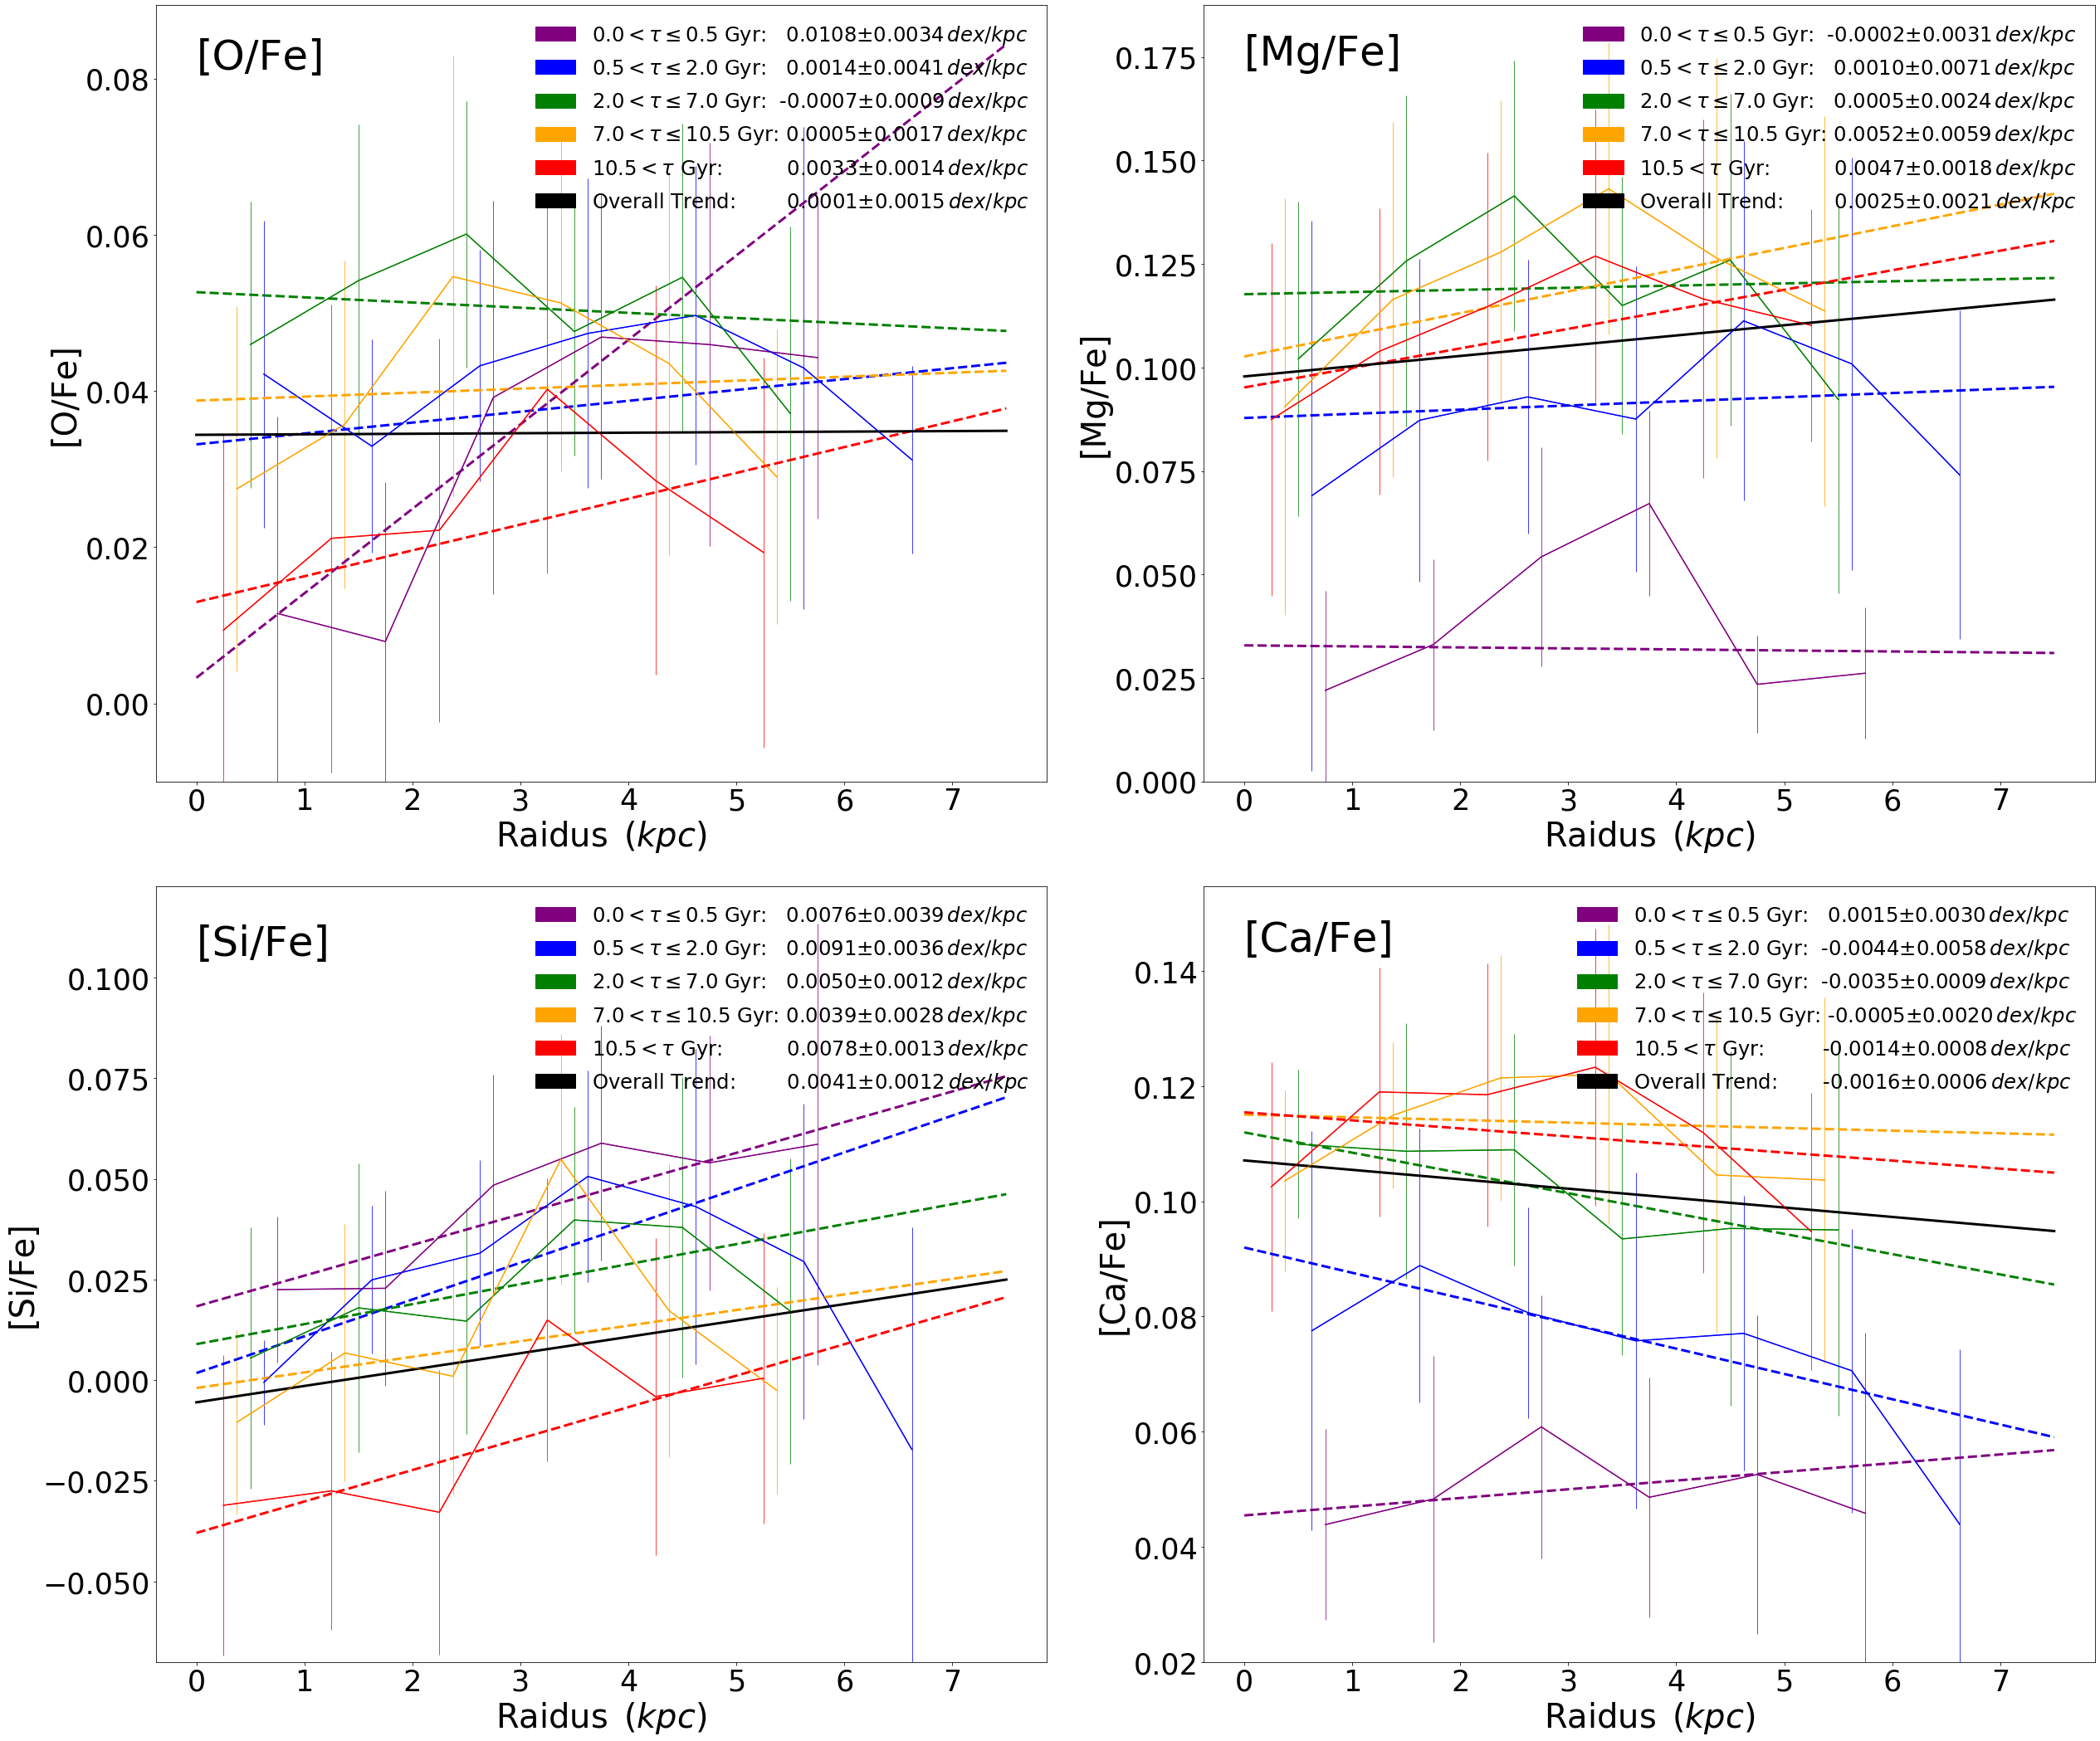

In [103]:
#############
### ALPHA ###
#############

# [3, 5, 7, 11]

alp = [3,5,7,11]

alp_sub = [221,222,223,224]


bottoms = [-0.01,0.0,-0.07,0.02]
tops = [0.11,0.208,0.12,0.1575]

matplotlib.rcParams.update({'font.size': 35})

plt.figure(figsize=[36,30])

for i,j in enumerate(alp): #range(len(iron)):
    xval = np.linspace(0.0,7.5)
    
    def youngtrendline(x):
        return younggrads['GRAD'][j]*x+younggrads['INTER'][j]
    def ylesstrendline(x):
        return ylessgrads['GRAD'][j]*x+ylessgrads['INTER'][j]
    def ymedtrendline(x):
        return ymedgrads['GRAD'][j]*x+ymedgrads['INTER'][j]
    def omedtrendline(x):
        return omedgrads['GRAD'][j]*x+omedgrads['INTER'][j]
    def oldtrendline(x):
        return oldgrads['GRAD'][j]*x+oldgrads['INTER'][j]
    def trendline(x):
        return overallgrads['GRAD'][j]*x+overallgrads['INTER'][j]
        
    plt.subplot(alp_sub[i])
    
    ### young
    plt.errorbar(np.arange(len(youngtrends['STATS'][j]))+0.5+0.25,youngtrends['STATS'][j],
                 yerr=youngtrends['SPREAD'][j],color='purple',ls='-',alpha=0.75,lw=1)
    plt.plot(np.arange(len(youngtrends['STATS'][j]))+0.5+0.25,youngtrends['STATS'][j],color='purple')
    plt.plot(xval,youngtrendline(xval),c='purple',lw=3.0,ls='--') #young
    
    ### yless
    plt.errorbar(np.arange(len(ylesstrends['STATS'][j]))+0.5+0.125,ylesstrends['STATS'][j],
                 yerr=ylesstrends['SPREAD'][j],color='blue',ls='-',alpha=0.75,lw=1)
    plt.plot(np.arange(len(ylesstrends['STATS'][j]))+0.5+0.125,ylesstrends['STATS'][j],color='blue')
    plt.plot(xval,ylesstrendline(xval),c='blue',lw=3.0,ls='--') #yless
    
    ### ymed
    plt.errorbar(np.arange(len(ymedtrends['STATS'][j]))+0.5,ymedtrends['STATS'][j],
                 yerr=ymedtrends['SPREAD'][j],color='green',ls='-',alpha=0.75,lw=1)
    plt.plot(np.arange(len(ymedtrends['STATS'][j]))+0.5,ymedtrends['STATS'][j],color='green')
    plt.plot(xval,ymedtrendline(xval),c='green',lw=3.0,ls='--') #ymed

    ### omed
    plt.errorbar(np.arange(len(omedtrends['STATS'][j]))+0.5-0.125,omedtrends['STATS'][j],
                 yerr=omedtrends['SPREAD'][j],color='orange',ls='-',alpha=0.75,lw=1)
    plt.plot(np.arange(len(omedtrends['STATS'][j]))+0.5-0.125,omedtrends['STATS'][j],color='orange')
    plt.plot(xval,omedtrendline(xval),c='orange',lw=3.0,ls='--') #omed
    

    ### old
    plt.errorbar(np.arange(len(oldtrends['STATS'][j]))+0.5-0.25,oldtrends['STATS'][j],
                 yerr=oldtrends['SPREAD'][j],color='red',ls='-',alpha=0.75,lw=1)
    plt.plot(np.arange(len(oldtrends['STATS'][j]))+0.5-0.25,oldtrends['STATS'][j],color='red')
    plt.plot(xval,oldtrendline(xval),c='red',lw=3.0,ls='--') #old
    
    ### overall
    plt.plot(xval,trendline(xval),c='k',lw=3.0)
    
    handles,labels = plt.gca().get_legend_handles_labels()
    empty_young = mpatches.Patch(color='purple',label='$0.0 < \\tau \leq 0.5$ Gyr')
    empty_yless = mpatches.Patch(color='blue',label='$0.5 < \\tau \leq 2.0$ Gyr')
    empty_ymed = mpatches.Patch(color='green',label='$2.0 < \\tau \leq 7.0$ Gyr')
    empty_omed = mpatches.Patch(color='orange',label='$7.0 < \\tau \leq 10.5$ Gyr')
    empty_old = mpatches.Patch(color='red',label='$10.5 < \\tau$ Gyr')
    empty_over = mpatches.Patch(color='black',label='Overall Trend')
    
    handles.append(empty_young)
    handles.append(empty_yless)
    handles.append(empty_ymed)
    handles.append(empty_omed)
    handles.append(empty_old)
    handles.append(empty_over)
    
    labels.append('$0.0 < \\tau \leq 0.5$ Gyr: {:>8.4f}$\pm {:.4f} \,dex/kpc$'.format(younggrads['GRAD'][j],
                                                                                      younggrads['GRAD_ERR'][j]))
    labels.append('$0.5 < \\tau \leq 2.0$ Gyr: {:>8.4f}$\pm {:.4f} \,dex/kpc$'.format(ylessgrads['GRAD'][j],
                                                                                      ylessgrads['GRAD_ERR'][j]))
    labels.append('$2.0 < \\tau \leq 7.0$ Gyr: {:>8.4f}$\pm {:.4f} \,dex/kpc$'.format(ymedgrads['GRAD'][j],
                                                                                      ymedgrads['GRAD_ERR'][j]))
    labels.append('$7.0 < \\tau \leq 10.5$ Gyr: {:>5.4f}$\pm {:.4f} \,dex/kpc$'.format(omedgrads['GRAD'][j],
                                                                                       omedgrads['GRAD_ERR'][j]))
    labels.append('$10.5 < \\tau$ Gyr: {:>15.4f}$\pm {:.4f} \,dex/kpc$'.format(oldgrads['GRAD'][j],
                                                                               oldgrads['GRAD_ERR'][j]))
    labels.append('Overall Trend: {:>13.4f}$\pm {:.4f} \,dex/kpc$'.format(overallgrads['GRAD'][j],
                                                                          overallgrads['GRAD_ERR'][j]))
    
    plt.legend(handles,labels,loc='upper right',fontsize='x-small',frameon=False)
    
    label_y = [0.08125,0.173,0.1055,0.1434]
    
    plt.text(0,label_y[i],'{}'.format(labs[j]),fontsize=50)

    plt.ylim(bottom = bottoms[i])

    plt.ylabel(r'{}'.format(labs[j]),fontsize=40)
    plt.xlabel(r'Raidus $\,(kpc$)',fontsize=40)
    
plt.tight_layout()
plt.savefig('alphaTrends.pdf',bbox_inches='tight')
plt.show()

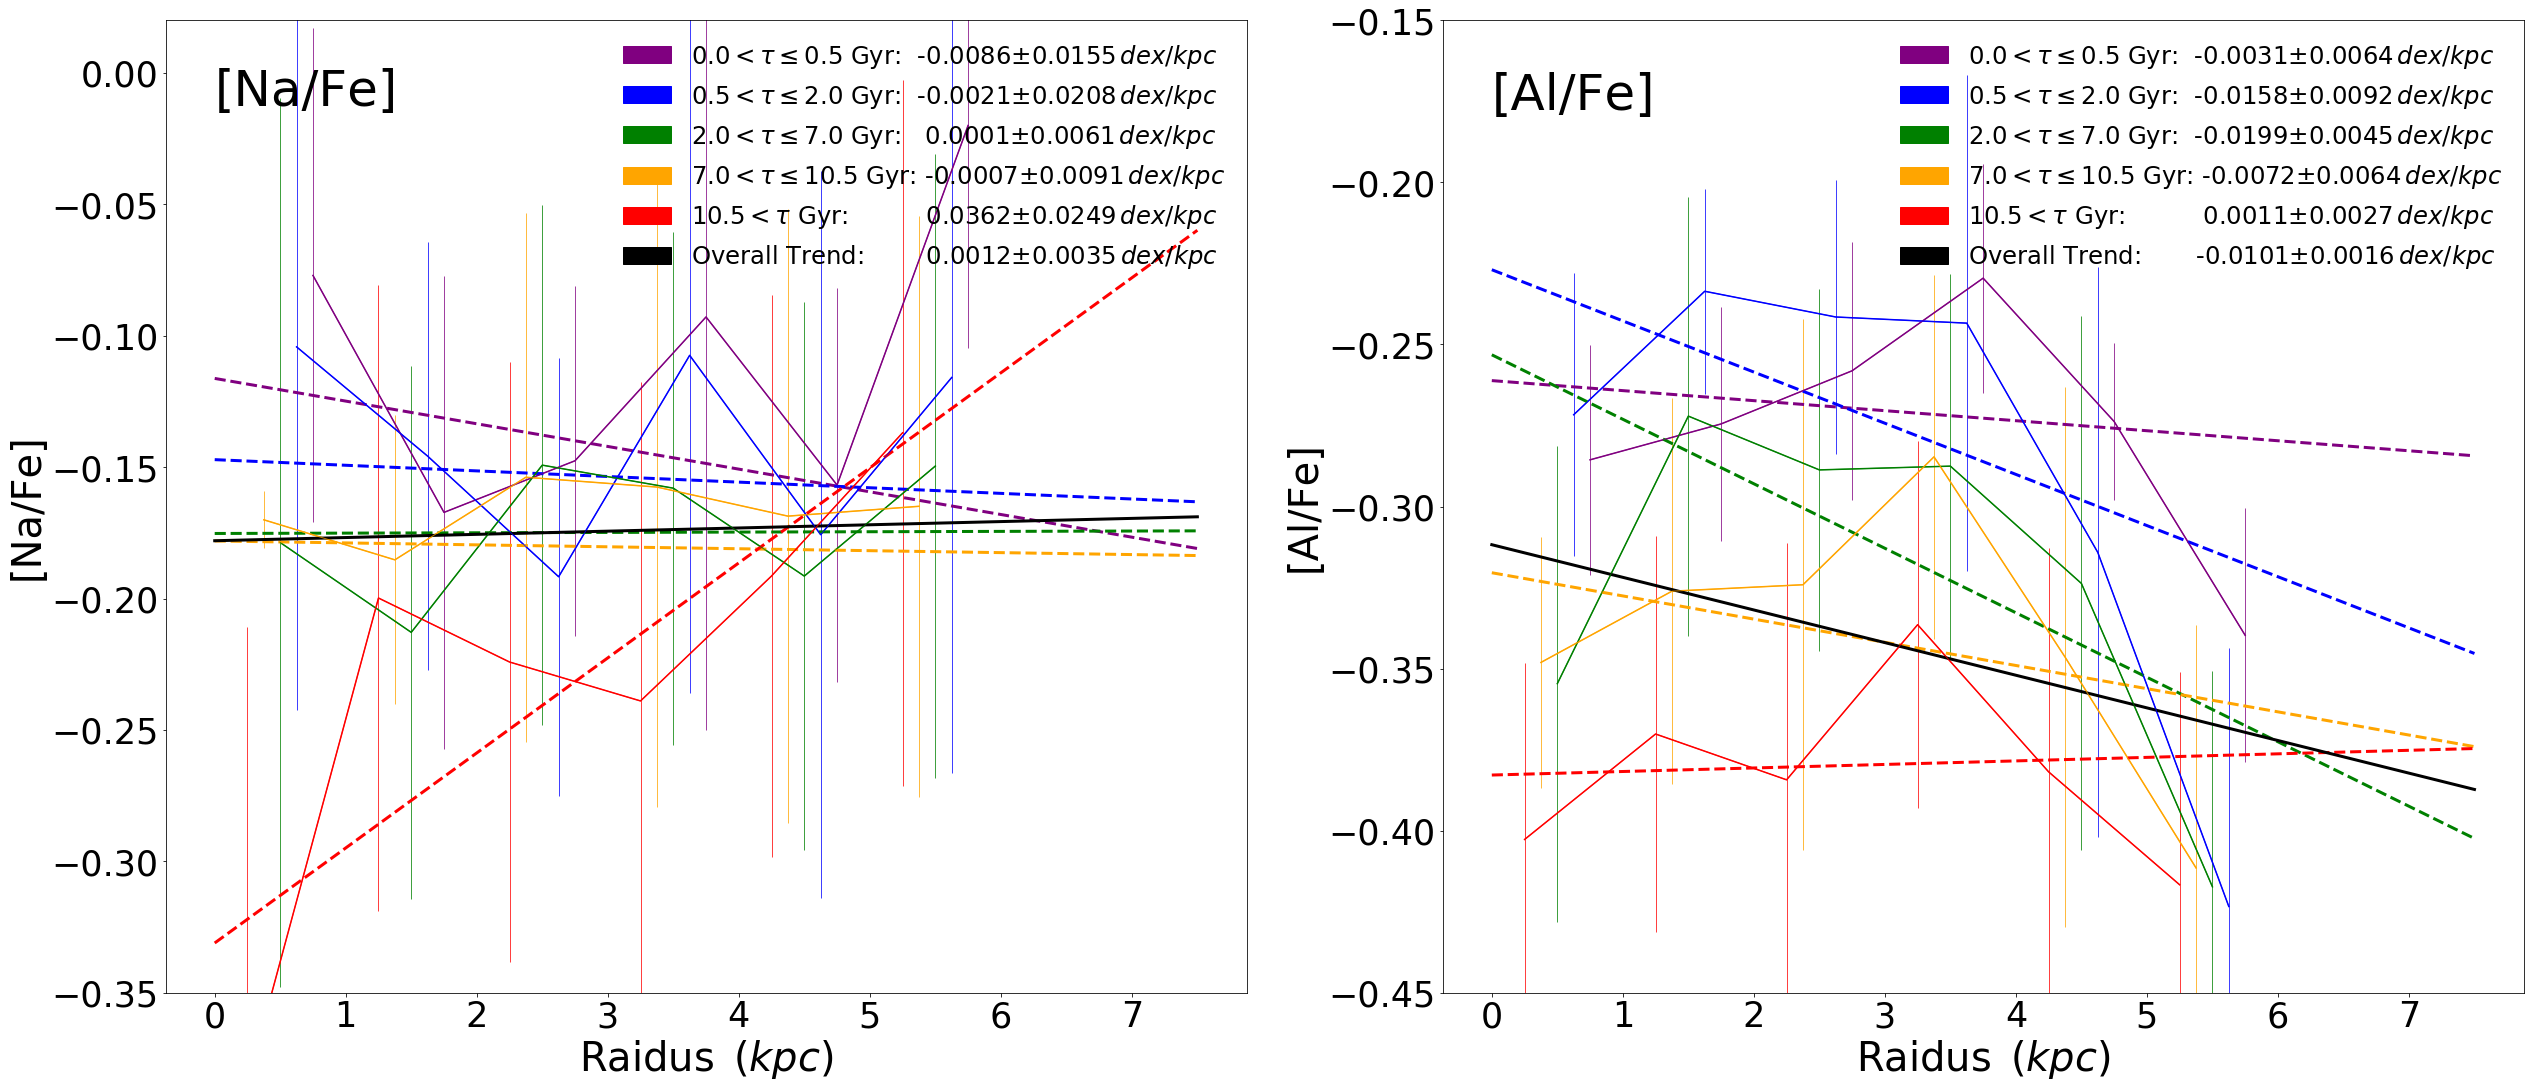

In [117]:
#############
### ODD Z ###
#############

# [4, 6]

oddz = [int(np.squeeze(np.where(np.asarray(labs)=='[Na/Fe]'))),
        int(np.squeeze(np.where(np.asarray(labs)=='[Al/Fe]')))]

oddz_sub = [121,122]

bottoms = [-0.35,-0.45]
tops = [0.02,-0.15]

matplotlib.rcParams.update({'font.size': 35})

plt.figure(figsize=[36,30])

for i,j in enumerate(oddz): #range(len(iron)):
    xval = np.linspace(0.0,7.5)
    
    def youngtrendline(x):
        return younggrads['GRAD'][j]*x+younggrads['INTER'][j]
    def ylesstrendline(x):
        return ylessgrads['GRAD'][j]*x+ylessgrads['INTER'][j]
    def ymedtrendline(x):
        return ymedgrads['GRAD'][j]*x+ymedgrads['INTER'][j]
    def omedtrendline(x):
        return omedgrads['GRAD'][j]*x+omedgrads['INTER'][j]
    def oldtrendline(x):
        return oldgrads['GRAD'][j]*x+oldgrads['INTER'][j]
    def trendline(x):
        return overallgrads['GRAD'][j]*x+overallgrads['INTER'][j]
        
    plt.subplot(alp_sub[i])
    
    ### young
    plt.errorbar(np.arange(len(youngtrends['STATS'][j]))+0.5+0.25,youngtrends['STATS'][j],
                 yerr=youngtrends['SPREAD'][j],color='purple',ls='-',alpha=0.75,lw=1)
    plt.plot(np.arange(len(youngtrends['STATS'][j]))+0.5+0.25,youngtrends['STATS'][j],color='purple')
    plt.plot(xval,youngtrendline(xval),c='purple',lw=3.0,ls='--') #young
    
    ### yless
    plt.errorbar(np.arange(len(ylesstrends['STATS'][j]))+0.5+0.125,ylesstrends['STATS'][j],
                 yerr=ylesstrends['SPREAD'][j],color='blue',ls='-',alpha=0.75,lw=1)
    plt.plot(np.arange(len(ylesstrends['STATS'][j]))+0.5+0.125,ylesstrends['STATS'][j],color='blue')
    plt.plot(xval,ylesstrendline(xval),c='blue',lw=3.0,ls='--') #yless
    
    ### ymed
    plt.errorbar(np.arange(len(ymedtrends['STATS'][j]))+0.5,ymedtrends['STATS'][j],
                 yerr=ymedtrends['SPREAD'][j],color='green',ls='-',alpha=0.75,lw=1)
    plt.plot(np.arange(len(ymedtrends['STATS'][j]))+0.5,ymedtrends['STATS'][j],color='green')
    plt.plot(xval,ymedtrendline(xval),c='green',lw=3.0,ls='--') #ymed

    ### omed
    plt.errorbar(np.arange(len(omedtrends['STATS'][j]))+0.5-0.125,omedtrends['STATS'][j],
                 yerr=omedtrends['SPREAD'][j],color='orange',ls='-',alpha=0.75,lw=1)
    plt.plot(np.arange(len(omedtrends['STATS'][j]))+0.5-0.125,omedtrends['STATS'][j],color='orange')
    plt.plot(xval,omedtrendline(xval),c='orange',lw=3.0,ls='--') #omed
    

    ### old
    plt.errorbar(np.arange(len(oldtrends['STATS'][j]))+0.5-0.25,oldtrends['STATS'][j],
                 yerr=oldtrends['SPREAD'][j],color='red',ls='-',alpha=0.75,lw=1)
    plt.plot(np.arange(len(oldtrends['STATS'][j]))+0.5-0.25,oldtrends['STATS'][j],color='red')
    plt.plot(xval,oldtrendline(xval),c='red',lw=3.0,ls='--') #old
    
    ### overall
    plt.plot(xval,trendline(xval),c='k',lw=3.0)
    
    handles,labels = plt.gca().get_legend_handles_labels()
    empty_young = mpatches.Patch(color='purple',label='$0.0 < \\tau \leq 0.5$ Gyr')
    empty_yless = mpatches.Patch(color='blue',label='$0.5 < \\tau \leq 2.0$ Gyr')
    empty_ymed = mpatches.Patch(color='green',label='$2.0 < \\tau \leq 7.0$ Gyr')
    empty_omed = mpatches.Patch(color='orange',label='$7.0 < \\tau \leq 10.5$ Gyr')
    empty_old = mpatches.Patch(color='red',label='$10.5 < \\tau$ Gyr')
    empty_over = mpatches.Patch(color='black',label='Overall Trend')
    
    handles.append(empty_young)
    handles.append(empty_yless)
    handles.append(empty_ymed)
    handles.append(empty_omed)
    handles.append(empty_old)
    handles.append(empty_over)
    
    labels.append('$0.0 < \\tau \leq 0.5$ Gyr: {:>8.4f}$\pm {:.4f} \,dex/kpc$'.format(younggrads['GRAD'][j],
                                                                                      younggrads['GRAD_ERR'][j]))
    labels.append('$0.5 < \\tau \leq 2.0$ Gyr: {:>8.4f}$\pm {:.4f} \,dex/kpc$'.format(ylessgrads['GRAD'][j],
                                                                                      ylessgrads['GRAD_ERR'][j]))
    labels.append('$2.0 < \\tau \leq 7.0$ Gyr: {:>8.4f}$\pm {:.4f} \,dex/kpc$'.format(ymedgrads['GRAD'][j],
                                                                                      ymedgrads['GRAD_ERR'][j]))
    labels.append('$7.0 < \\tau \leq 10.5$ Gyr: {:>5.4f}$\pm {:.4f} \,dex/kpc$'.format(omedgrads['GRAD'][j],
                                                                                       omedgrads['GRAD_ERR'][j]))
    labels.append('$10.5 < \\tau$ Gyr: {:>15.4f}$\pm {:.4f} \,dex/kpc$'.format(oldgrads['GRAD'][j],
                                                                               oldgrads['GRAD_ERR'][j]))
    labels.append('Overall Trend: {:>13.4f}$\pm {:.4f} \,dex/kpc$'.format(overallgrads['GRAD'][j],
                                                                          overallgrads['GRAD_ERR'][j]))
    
    plt.legend(handles,labels,loc='upper right',fontsize='x-small',frameon=False)
    
    label_y = [-0.0125,-0.1775]
    
    plt.text(0,label_y[i],'{}'.format(labs[j]),fontsize=50)

    plt.ylim(bottoms[i],tops[i])

    plt.ylabel(r'{}'.format(labs[j]),fontsize=40)
    plt.xlabel(r'Raidus $\,(kpc$)',fontsize=40)
    
plt.tight_layout()
plt.savefig('oddzTrends.pdf',bbox_inches='tight')
plt.show()

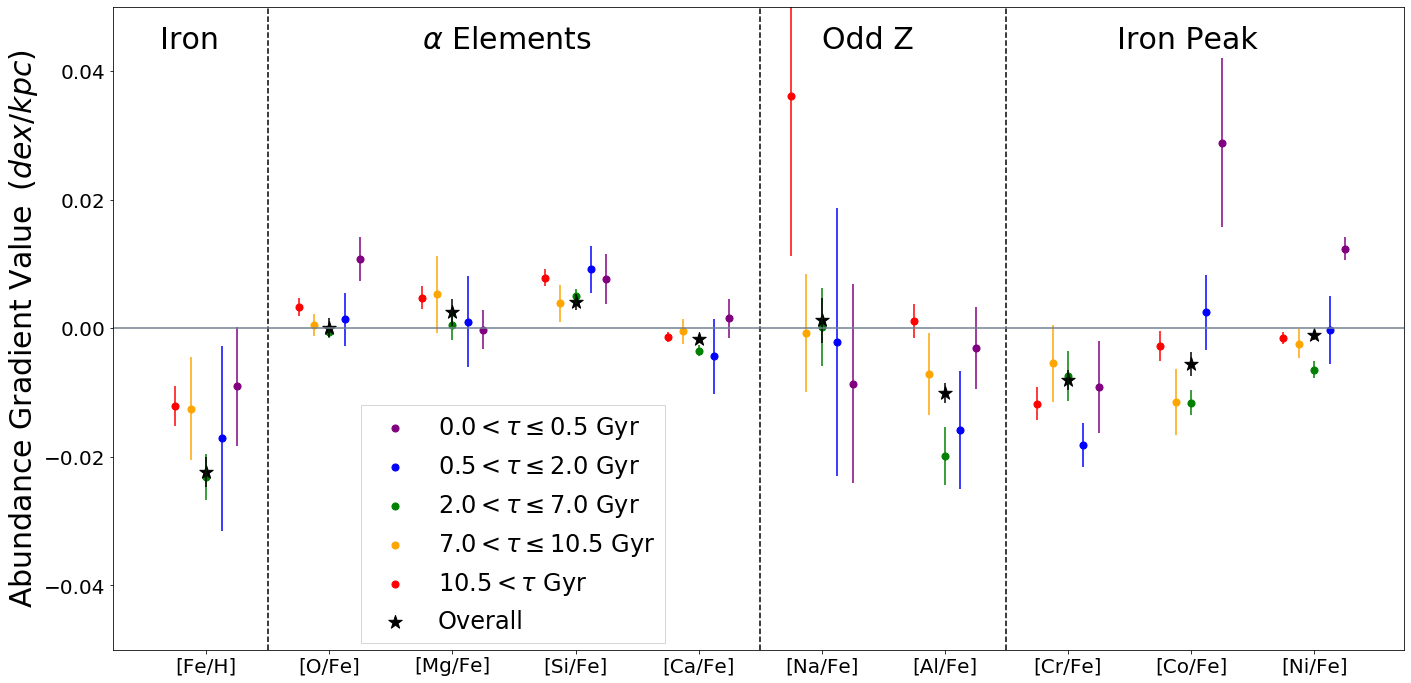

In [102]:
####################
### Summary plot ###
####################

# elements: O, Na, Mg, Al, Si, Ca, Cr, Fe, Co, Ni, V

idx = [np.squeeze(np.where(np.asarray(elems)=='FE_H')),np.squeeze(np.where(np.asarray(elems)=='O_FE')),
       np.squeeze(np.where(np.asarray(elems)=='MG_FE')),np.squeeze(np.where(np.asarray(elems)=='SI_FE')),
       np.squeeze(np.where(np.asarray(elems)=='CA_FE')),np.squeeze(np.where(np.asarray(elems)=='NA_FE')),
       np.squeeze(np.where(np.asarray(elems)=='AL_FE')),np.squeeze(np.where(np.asarray(elems)=='CR_FE')),
       np.squeeze(np.where(np.asarray(elems)=='CO_FE')),np.squeeze(np.where(np.asarray(elems)=='NI_FE'))]#,
       #np.squeeze(np.where(np.asarray(elems)=='V_FE'))]

good_young = []
good_yless = []
good_ymed = []
good_omed = []
good_old = []
good_over = []

err_young = []
err_yless = []
err_ymed = []
err_omed = []
err_old = []
err_over = []

for i in idx:
    good_young.append(younggrads['GRAD'][i])
    good_yless.append(ylessgrads['GRAD'][i])
    good_ymed.append(ymedgrads['GRAD'][i])
    good_omed.append(omedgrads['GRAD'][i])
    good_old.append(oldgrads['GRAD'][i])
    good_over.append(overallgrads['GRAD'][i])
    
    err_young.append(younggrads['GRAD_ERR'][i])
    err_yless.append(ylessgrads['GRAD_ERR'][i])
    err_ymed.append(ymedgrads['GRAD_ERR'][i])
    err_omed.append(omedgrads['GRAD_ERR'][i])
    err_old.append(oldgrads['GRAD_ERR'][i])
    err_over.append(overallgrads['GRAD_ERR'][i])

matplotlib.rcParams.update({'font.size': 20})
fig = plt.figure(figsize=[20,10])

plt.scatter(np.add(np.arange(10),0.25),good_young,c='purple',label='$0.0 < \\tau \leq 0.5$ Gyr',s=50)
plt.errorbar(np.add(np.arange(10),0.25),good_young,yerr=err_young,c='purple',ls='none')

plt.scatter(np.add(np.arange(10),0.125),good_yless,c='blue',label='$0.5 < \\tau \leq 2.0$ Gyr',s=50)
plt.errorbar(np.add(np.arange(10),0.125),good_yless,yerr=err_yless,c='blue',ls='none')

plt.scatter([0,1,2,3,4,5,6,7,8,9],good_ymed,c='green',label='$2.0 < \\tau \leq 7.0$ Gyr',s=50)
plt.errorbar([0,1,2,3,4,5,6,7,8,9],good_ymed,yerr=err_ymed,c='green',ls='none')

plt.scatter(np.subtract(np.arange(10),0.125),good_omed,c='orange',label='$7.0 < \\tau \leq 10.5$ Gyr',s=50)
plt.errorbar(np.subtract(np.arange(10),0.125),good_omed,yerr=err_omed,c='orange',ls='none')

plt.scatter(np.subtract(np.arange(10),0.25),good_old,c='red',label='$10.5 < \\tau $ Gyr',s=50)
plt.errorbar(np.subtract(np.arange(10),0.25),good_old,yerr=err_old,c='red',ls='none')

plt.scatter([0,1,2,3,4,5,6,7,8,9],good_over,marker='*',c='black',label='Overall',s=200)
plt.errorbar([0,1,2,3,4,5,6,7,8,9],good_over,yerr=err_over,c='black',ls='none')

xplotlab = ['[Fe/H]','[O/Fe]','[Mg/Fe]','[Si/Fe]','[Ca/Fe]','[Na/Fe]','[Al/Fe]','[Cr/Fe]','[Co/Fe]',
            '[Ni/Fe]']#,'[V/Fe]']

xplotpos = [0,1,2,3,4,5,6,7,8,9]#,10] 
plt.xticks(xplotpos,xplotlab)

plt.axvline(0.5,c='k',ls='--')
plt.axvline(4.5,c='k',ls='--')
plt.axvline(6.5,c='k',ls='--')
plt.axhline(0.0,c='slategrey',ls='-')
plt.ylabel('Abundance Gradient Value $\,(dex/kpc)$',fontsize=30)

# plt.gca().set_ylim(top=0.05)

plt.text(-0.375,0.0435,'Iron',fontsize=30)
plt.text(1.75,0.0435,'$\\alpha$ Elements',fontsize=30)
plt.text(5.0,0.0435,'Odd Z',fontsize=30)
plt.text(7.4,0.0435,'Iron Peak',fontsize=30)

# plt.ylim(bottom=-0.045)
plt.ylim(-0.05,0.05)

plt.legend(loc=(0.1925,0.01),frameon=True,fancybox=False,fontsize='large')
plt.tight_layout()
plt.savefig('gradientSummaryplot.pdf',bbox_inches='tight')
plt.show()

In [325]:
sumtable = Table()

tab_labs = ['{{[M/H]}}','{{[C/Fe]}}','{{[N/Fe]}}','{{[O/Fe]}}','{{[Na/Fe]}}','{{[Mg/Fe]}}','{{[Al/Fe]}}',
            '{{[Si/Fe]}}','{{[P/Fe]}}','{{[S/Fe]}}','{{[K/Fe]}}','{{[Ca/Fe]}}','{{[Ti/Fe]}}','{{[TiII/FE]}}',
            '{{[V/Fe]}}','{{[Cr/Fe]}}','{{[Mn/Fe]}}','{{[Fe/H]}}','{{[Co/Fe]}}','{{[Ni/Fe]}}','{{[Cu/Fe]}}',
            '{{[Ge_Fe]}}','{{[Rb/Fe]}}','{{[Ce/Fe]}}','{{[Nd/Fe]}}','{{[Yb/Fe]}}']

str_name = []
str_young = []
str_yless = []
str_ymed = []
str_omed = []
str_old = []
str_over = []

for i in idx:
    str_name.append('{}'.format(tab_labs[i]))
    str_young.append('${:.4f} \pm {:.4f}$'.format(younggrads['GRAD'][i],younggrads['GRAD_ERR'][i]))
    str_yless.append('${:.4f} \pm {:.4f}$'.format(ylessgrads['GRAD'][i],ylessgrads['GRAD_ERR'][i]))
    str_ymed.append('${:.4f} \pm {:.4f}$'.format(ymedgrads['GRAD'][i],ymedgrads['GRAD_ERR'][i]))
    str_omed.append('${:.4f} \pm {:.4f}$'.format(omedgrads['GRAD'][i],omedgrads['GRAD_ERR'][i]))
    str_old.append('${:.4f} \pm {:.4f}$'.format(oldgrads['GRAD'][i],oldgrads['GRAD_ERR'][i]))
    str_over.append('${:.4f} \pm {:.4f}$'.format(overallgrads['GRAD'][i],overallgrads['GRAD_ERR'][i]))

sumtable['[X/Fe]']=Column(np.asarray(labs)[np.asarray(idx)])
sumtable['Overall']=Column(str_over,unit='dex/kpc')
sumtable[r'$0.0 < \tau \leq 0.5$']=Column(str_young,unit='dex/kpc')
sumtable[r'$0.5 < \tau \leq 2.0$']=Column(str_yless,unit='dex/kpc')
sumtable[r'$2.0 < \tau \leq 7.0$']=Column(str_ymed,unit='dex/kpc')
sumtable[r'$7.0 < \tau \leq 10.5$']=Column(str_omed,unit='dex/kpc')
sumtable[r'$10.5 < \tau $']=Column(str_old,unit='dex/kpc')

ascii.write(sumtable, format='aastex')

\begin{deluxetable}{ccccccc}
\tablehead{\colhead{[X/Fe]} & \colhead{Overall} & \colhead{$0.0 < \tau \leq 0.5$} & \colhead{$0.5 < \tau \leq 2.0$} & \colhead{$2.0 < \tau \leq 7.0$} & \colhead{$7.0 < \tau \leq 10.5$} & \colhead{$10.5 < \tau $}\\ \colhead{ } & \colhead{$\mathrm{dex\,kpc^{-1}}$} & \colhead{$\mathrm{dex\,kpc^{-1}}$} & \colhead{$\mathrm{dex\,kpc^{-1}}$} & \colhead{$\mathrm{dex\,kpc^{-1}}$} & \colhead{$\mathrm{dex\,kpc^{-1}}$} & \colhead{$\mathrm{dex\,kpc^{-1}}$}}
\startdata
[Fe/H] & $-0.0224 \pm 0.0024$ & $-0.0090 \pm 0.0092$ & $-0.0171 \pm 0.0144$ & $-0.0232 \pm 0.0036$ & $-0.0125 \pm 0.0081$ & $-0.0121 \pm 0.0031$ \\
[O/Fe] & $0.0001 \pm 0.0015$ & $0.0108 \pm 0.0034$ & $0.0014 \pm 0.0041$ & $-0.0007 \pm 0.0009$ & $0.0005 \pm 0.0017$ & $0.0033 \pm 0.0014$ \\
[Mg/Fe] & $0.0025 \pm 0.0021$ & $-0.0002 \pm 0.0031$ & $0.0010 \pm 0.0071$ & $0.0005 \pm 0.0024$ & $0.0052 \pm 0.0059$ & $0.0047 \pm 0.0018$ \\
[Si/Fe] & $0.0041 \pm 0.0012$ & $0.0076 \pm 0.0039$ & $0.0091 \pm 0.0036$ & 

In [98]:
idx

[array(17),
 array(3),
 array(5),
 array(7),
 array(11),
 array(4),
 array(6),
 array(15),
 array(18),
 array(19)]